In [51]:
# === Core data handling & utilities =========================================
import numpy as np                  # numerical arrays, vectorized ops
import pandas as pd                 # tabular data structures (DataFrame)
import pickle                       # model/object serialization to disk

# === Visualization ===========================================================
import matplotlib.pyplot as plt     # plotting
from matplotlib.colors import ListedColormap  # custom colormaps for plots
import seaborn as sns               # statistical plotting (optional)
import missingno as msno            # missing-value visualization

# === Model evaluation & metrics =============================================
from sklearn.metrics import (
    recall_score,
    fbeta_score,
    make_scorer,
    confusion_matrix,
)
from sklearn.metrics import ConfusionMatrixDisplay  # pretty confusion matrix

# === Data splitting & cross-validation ======================================
from sklearn.model_selection import (
    train_test_split,      # holdout split
    StratifiedKFold,       # CV preserving class ratios
    cross_val_score,       # quick CV scoring
    GridSearchCV,          # exhaustive search
)

# === Missing-value imputation ===============================================
from sklearn.impute import SimpleImputer           # mean/median/mode/constant
from sklearn.experimental import enable_iterative_imputer  # noqa: F401; enables IterativeImputer
from sklearn.impute import IterativeImputer        # multivariate (regression-based) imputation

# === Encoding for categorical variables =====================================
from sklearn.preprocessing import OneHotEncoder    # one-hot / dummy variables
from category_encoders import BinaryEncoder  # alternative encoders

# === Feature scaling (numerical) ============================================
from sklearn.preprocessing import (
    RobustScaler,          # robust to outliers (IQR-based)
)

# === Pipelines & column-wise preprocessing ==================================
from sklearn.pipeline import Pipeline              # chaining steps end-to-end
from sklearn.compose import ColumnTransformer      # apply transforms per column group

# === Base algorithms (classifiers) ==========================================
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# === Ensemble methods ========================================================
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from xgboost import XGBClassifier                  # gradient boosting (XGBoost)
from lightgbm import LGBMClassifier                # gradient boosting (LightGBM)

# === Imbalanced learning: resampling & pipelines =============================
from imblearn.over_sampling import (
    RandomOverSampler,     # naive minority oversampling
    SMOTE,                 # synthetic minority oversampling
)
from imblearn.under_sampling import (
    RandomUnderSampler,    # random majority undersampling
)
from imblearn.pipeline import Pipeline as ImbPipeline  # pipeline that supports samplers

# === Hyperparameter search spaces & optimization ============================
from hyperopt import hp, tpe, Trials, fmin, space_eval  # Bayesian HPO (Hyperopt)
from hyperopt.pyll import scope

# === Explainability ==========================================================
import shap                                       # model interpretability (SHAP values)


# **Travel Insurance Claim**
Naufal Fajar Revanda // JCDS-0808-009

## **1. Business Overview**

### **Business Understanding**

**<u>Context</u>**

Travel insurance is a type of insurance that provides protection as long as we travel both domestically and abroad. Several countries have even required travelers to have travel insurance, for example, countries in Europe and America. The amount of premium depends on the coverage desired, the length of the trip, and the purpose of the trip. A company engaged in travel insurance wants to know the economic class policyholder who will submit an insurance claim for coverage. Policyholder data at insurance companies is historical data consisting of destinations, insurance products, and so on.

Target:

**1** : Submit insurance claim

**0** : Not submit claim 

**<u>Problem statement</u>**

A travel insurance company wants to identify which policyholders are likely to file a claim on their travel insurance. Currently, customer risk is determined only based on general rules. For example based on travel duration or destination, which is less accurate is asessing the actual probability of a claim.
this can leat to two main problems:

1.  **Financial loss** iif the insurance premium is too low for high rist customer

2. **Loss of business opportunities** if the insurance premium is too high for low risk customers, making them reluctant to buy a policy

With their historical data, the company needs a machine learning based predictive model that can help identify the characteristics of high risk customers and more accurately estimate the likelihood of a claim. This predictive model is not intended to reject cusatomer but to ensure the premium are fair, the company remains financially healthy and all claims can be paid smoothly.

**Another essential things to think about is how to ensure the claims is genuine, not fraudulent**

**<u>Goals</u>**
1. **Building a machine learning model** to predict the probability that a policyholder will file a travel insurance claim.

2. **Identifying the main factors (features)** that influence a claim being filed, so the company can understand customer risk patterns.

3. **Supporting business decisions**, such as more accurate premium determination, marketing strategies, and company risk management.

4. **Increasing operational efficiency** by reducing unexpected claims and maximizing profit through risk-based customer segmentation.


### **Business Metrics**

|                         | **Actual: Claim**                                                                                                                                                                                            | **Actual: No Claim**                                                                                                                                                                                                                                          |
| ----------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Predicted: Claim**    | **True Positive (TP)**  <br>✔ Correctly predicts claim. <br>✔ Premium already adjusted higher, so loss is controlled. <br>✔ Company can manage risk effectively.                                             | **False Positive (FP)**  <br>✘ Predicted claim but no claim occurs. <br>✘ Company must set aside **65,000 USD** per policy as standby funds. <br>✘ Opportunity cost = **3,250 USD/year** (assuming a 5% annual return if invested in bonds or time deposits). |
| **Predicted: No Claim** | **False Negative (FN)**  <br>✘ Predicted no claim but claim occurs. <br>✘ Biggest risk: company bears unanticipated claim. <br>✘ Cost up to **65,000 USD per claim**. <br>✘ FN is \~20× more costly than FP. | **True Negative (TN)**  <br>✔ Correctly predicts no claim. <br>✔ Standard premium applies. <br>✔ Stable and profitable outcome.                                                                                                                               |


**Implication**
- False Negatives (FN) must be minimized -> recall becomes very important.
- False Positives (FP) also create negative impacts through opportunity costs.
- Therefore, recall is prioritized as the main evaluation metric.


**Price References for Domestic and International Travel Insurance**:
1. [OONA](https://myoona.id/blog/bepergian/berapa-harga-asuransi-perjalanan/)
2. [BCA Insurance](https://www.bcainsurance.co.id/product/detail/travel-insurance)
3. [Axa](https://mypage.axa.co.id/smarttravel/international?utm_source=google&utm_medium=paidsearch&utm_content=TextAds&gad_source=1&gad_campaignid=22362456862&gbraid=0AAAAA_DvgsOBgw4ROrMwA4Yoi14dIJw6w&gclid=Cj0KCQjwn8XFBhCxARIsAMyH8BuTiMgwDXONV2YsAcQGvYG1_VR64YNqrk0r2x2VBW_74lHhS-VaiBwaAk_CEALw_wcB)
4. [Allianz](https://www.allianz.co.id/produk/asuransi-umum/asuransi-perjalanan.html)

### **Feature Description**

**<u>Dataset</u>**

[Travel Insurance](https://www.kaggle.com/datasets/mhdzahier/travel-insurance)

**Features**

| Attributes            | Description                                    |
|-----------------------|------------------------------------------------|
| **Agency**            | Name of agency                                 |
| **Agency Type**       | Type of travel insurance agencies              |
| **Distribution Channel** | Channel of travel insurance agencies        |
| **Product Name**      | Name of the travel insurance products          |
| **Gender**            | Gender of insured                              |
| **Duration**          | Duration of travel                             |
| **Destination**       | Destination of travel                          |
| **Net Sales**         | Amount of sales of travel insurance policies   |
| **Commission (in value)** | Commission received for travel insurance agency |
| **Age**               | Age of insured                                |
| **Claim**             | Claim status                                   |


## **2. Data Understanding**

In [52]:
# load dataset
df = pd.read_csv(r'D:\Documents\0. JCDS\Module 3 - Machine Learning\Capstone Project Module 3\dataset\data_travel_insurance.csv')

# rename -> replace white space with underscore
df = df.rename(columns={
    'Agency Type':'Agency_type',
    'Distribution Channel':'Distribution_channel',
    'Product Name':'Product_name',
    'Net Sales':'Net_sales',
    'Commision (in value)':'Commision'
})
df.head()

,Agency,Agency_type,Distribution_channel,Product_name,Gender,Duration,Destination,Net_sales,Commision,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


In [54]:
# rows and columns
df.shape

(44328, 11)

In [55]:
# descriptive statistics
display(df.describe().T, df.describe(include='object').T)

,count,mean,std,min,25%,50%,75%,max
Duration,44328.0,49.424292,109.153961,-1.0,9.0,22.0,53.00,4881.0
Net_sales,44328.0,40.550948,48.661970,-357.5,18.0,26.5,48.00,810.0
Commision,44328.0,9.707692,19.625637,0.0,0.0,0.0,11.55,283.5
Age,44328.0,39.925600,13.954926,0.0,35.0,36.0,43.00,118.0


,count,unique,top,freq
Agency,44328,16,EPX,24656
Agency_type,44328,2,Travel Agency,32113
Distribution_channel,44328,2,Online,43572
Product_name,44328,26,Cancellation Plan,12979
Gender,12681,2,M,6504
Destination,44328,138,SINGAPORE,9267
Claim,44328,2,No,43651


**Findings**:
- 4470 duplicated rows: not necessary to drop since they just reflect repeated real transactions
- `Net_sales`: contains data with negative values. This is a normal condition, as negative Net Sales can be interpreted as a loss from product sales after deducting returns, allowances, and discounts
- `Duration`: contains 2 rows of minus value
- `Gender`: More than 70% of the rows contain missing values, which makes it difficult to reliably predict the results due to the lack of data. Moreover, based on AI Ethics, which prioritize the principle of fairness, any decision derived from a Machine Learning model should not discriminate against religion, ethnicity, or certain groups. Therefore, the gender column will be dropped
- `Destination`: has vary value (138 unique value)
- `Age`: Max age is 118 which unlikely. Thus can be assumed as outliers
- `Claim`: Is an object, need to be a binary to ease the modeling


## **3. Data Cleaning**

### **Duplicates**

The process is disthinguished into **two main steps**:
1. Conflict Resolution: Drop all sets of rows that **have identical features but conflicting target** values (e.g., both 1 and 0 for the same features)
2. Exact Duplicate Removal: After resolving conflicts, **drop any remaining rows that are perfect duplicates**, keeping only a single unique record


In [56]:
# duplicate check
duplicates = df[df.duplicated()]
if duplicates.empty:
    print("There are no duplicates")
else:
    print(f"Number of duplicated rows: {df.duplicated().sum()}")

duplicates.sort_values(['Agency', 'Product_name'])

Number of duplicated rows: 4667


,Agency,Agency_type,Distribution_channel,Product_name,Gender,Duration,Destination,Net_sales,Commision,Age,Claim
22009,ART,Airlines,Online,24 Protect,M,3,MALAYSIA,4.99,1.75,48,No
31570,ART,Airlines,Online,Value Plan,M,18,CHINA,61.00,21.35,118,No
43985,ART,Airlines,Online,Value Plan,M,31,THAILAND,29.00,10.15,118,No
14317,C2B,Airlines,Online,Annual Gold Plan,M,364,SINGAPORE,333.00,83.25,35,No
26521,C2B,Airlines,Online,Annual Gold Plan,F,365,SINGAPORE,389.35,97.34,33,No
...,...,...,...,...,...,...,...,...,...,...,...
41678,TST,Travel Agency,Offline,Travel Cruise Protect,F,71,THAILAND,30.00,10.50,46,No
42018,TST,Travel Agency,Offline,Travel Cruise Protect,F,72,MALAYSIA,30.00,10.50,69,No
7886,TTW,Travel Agency,Offline,Child Comprehensive Plan,M,369,SINGAPORE,74.00,0.00,9,No
29771,TTW,Travel Agency,Offline,Individual Comprehensive Plan,M,364,SINGAPORE,97.00,0.00,42,No


In [57]:
duplicate_diff_claim = df.groupby([col for col in df.columns if col != "Claim"])["Claim"].nunique().reset_index(name="n_labels").query("n_labels > 1")
duplicate_diff_claim.head()

,Agency,Agency_type,Distribution_channel,Product_name,Gender,Duration,Destination,Net_sales,Commision,Age,n_labels
330,C2B,Airlines,Online,Annual Gold Plan,M,365,SINGAPORE,333.00,83.25,61,2
402,C2B,Airlines,Online,Annual Silver Plan,F,364,SINGAPORE,216.00,54.00,42,2
423,C2B,Airlines,Online,Annual Silver Plan,F,364,SINGAPORE,291.75,72.94,29,2
436,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,187.85,46.96,26,2
457,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.00,54.00,33,2


In [58]:
# feature columns without the target
label_col = "Claim"
feature_cols = [col for col in df.columns if col != label_col]

# rows that have similar value but different label (claim)
conflict_keys = set(duplicate_diff_claim[feature_cols].apply(tuple, axis=1))

# create a helper column _key
df["_key"] = df[feature_cols].apply(tuple, axis=1)

# drop all rows that are in the conflict group
df = df[~df["_key"].isin(conflict_keys)].drop(columns="_key")
print("Total rows after drop the duplicate with different label (claim):", len(df))

# drop exact duplicates (same features + label), keep only 1
df = df.drop_duplicates(keep="first")
print("Total rows after drop exact duplicates (final):", len(df))

Total rows after drop the duplicate with different label (claim): 44234
Total rows after drop exact duplicates (final): 39579


In [59]:
# duplicate check
duplicates = df[df.duplicated()]
if duplicates.empty:
    print("There are no duplicates")
else:
    print(f"Number of duplicated rows: {df.duplicated().sum()}")

duplicates.sort_values(['Agency', 'Product_name'])

There are no duplicates


,Agency,Agency_type,Distribution_channel,Product_name,Gender,Duration,Destination,Net_sales,Commision,Age,Claim


### **Missing Values**

In [60]:
# missing values check
missing_value_check = pd.DataFrame({
    "type": df.dtypes.values,
    "total": [df.shape[0]] * len(df.columns),
    "null_count": df.isna().sum().values,
    "null_pct": (df.isna().sum() / df.shape[0] * 100).round(2).values,
    "unique_count": df.nunique().values,
    "unique_sample": [df[col].unique()[:5] for col in df.columns],
}, index=df.columns).rename_axis('column')
missing_value_check

,type,total,null_count,null_pct,unique_count,unique_sample
column,,,,,,
Agency,object,39579,0,0.0,16,"[C2B, EPX, JZI, CWT, LWC]"
Agency_type,object,39579,0,0.0,2,"[Airlines, Travel Agency]"
Distribution_channel,object,39579,0,0.0,2,"[Online, Offline]"
Product_name,object,39579,0,0.0,26,"[Annual Silver Plan, Cancellation Plan, Basic ..."
Gender,object,39579,27667,69.9,2,"[F, nan, M]"
Duration,int64,39579,0,0.0,437,"[365, 4, 19, 20, 8]"
Destination,object,39579,0,0.0,138,"[SINGAPORE, MALAYSIA, INDIA, UNITED STATES, KO..."
Net_sales,float64,39579,0,0.0,1006,"[216.0, 10.0, 22.0, 112.0, 16.0]"
Commision,float64,39579,0,0.0,915,"[54.0, 0.0, 7.7, 4.0, 9.1]"


<Axes: >

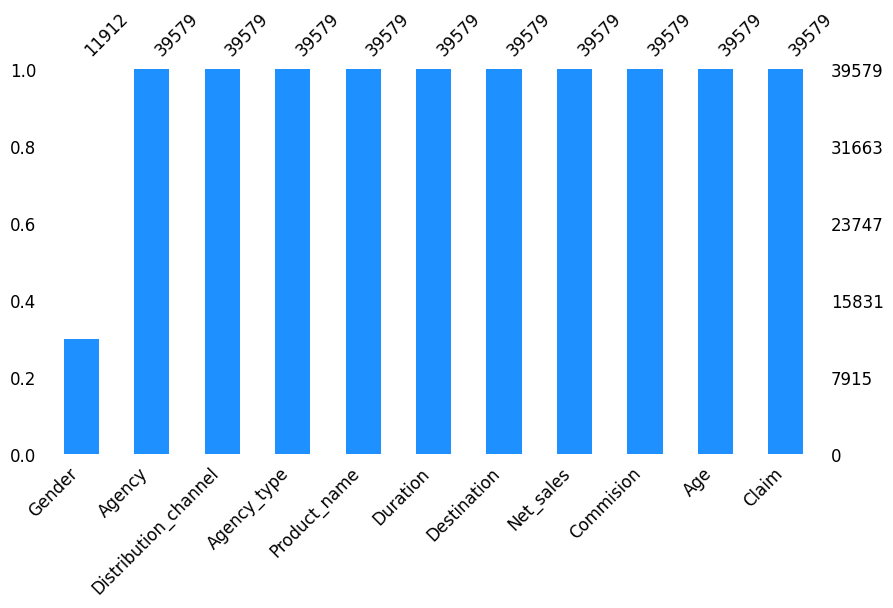

In [62]:
# missing value check by missingno
msno.bar(df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12)

In [63]:
# drop the 'Gender' column
df.drop(columns=['Gender'], inplace=True)

As explained above, the `Gender` column is removed due to an excessive percentage of missing values, its lack of relevance to travel insurance claims, and ethical considerations.

### **Removing Irrelevant Data**

In [64]:
# remove the negative value and duration morethan equal to 4000
df.drop(df[(df['Duration'] <= 0) | (df['Duration'] >= 4000)].index, inplace=True)

#  remove the suspicious age
df.drop(df[df['Age'] == 118].index, inplace=True)

# reset index for neat dataFrame
df.reset_index(drop=True, inplace=True)

In [65]:
display(df.describe().T, df.describe(include='object').T)

,count,mean,std,min,25%,50%,75%,max
Duration,39060.0,50.810215,74.678175,1.0,11.0,25.0,57.00,740.00
Net_sales,39060.0,42.047178,49.602070,-357.5,19.0,28.0,49.50,682.00
Commision,39060.0,10.271456,20.279449,0.0,0.0,0.0,11.88,262.76
Age,39060.0,38.976754,10.479616,0.0,34.0,36.0,44.00,88.00


,count,unique,top,freq
Agency,39060,15,EPX,20961
Agency_type,39060,2,Travel Agency,28076
Distribution_channel,39060,2,Online,38388
Product_name,39060,26,Cancellation Plan,11007
Destination,39060,136,SINGAPORE,8158
Claim,39060,2,No,38432


The dataset was published on Kaggle in 2018, in 2019, Guinness World Records verified that the longest-living person at that time reached 117 years and passed away in 2018. Moreover, life expectancy data shows that Europe has the highest average, at around 80 years, still far below 100. Therefore having `Age` of 118 years is highly unlikely and may indicate error

references:
1. [Guinness World Records](https://www.guinnessworldrecords.com/world-records/78965-oldest-people-ever-lived-top-ten-table)
2. [Life Expectancy](https://ourworldindata.org/life-expectancy)

### **Map Target**

In [66]:
df['Claim'].value_counts(normalize=True)

Claim
No     0.983922
Yes    0.016078
Name: proportion, dtype: float64

In [67]:
df['Claim'] = df['Claim'].map({
    'Yes': 1,
    'No': 0
}).astype(int)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39060 entries, 0 to 39059
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                39060 non-null  object 
 1   Agency_type           39060 non-null  object 
 2   Distribution_channel  39060 non-null  object 
 3   Product_name          39060 non-null  object 
 4   Duration              39060 non-null  int64  
 5   Destination           39060 non-null  object 
 6   Net_sales             39060 non-null  float64
 7   Commision             39060 non-null  float64
 8   Age                   39060 non-null  int64  
 9   Claim                 39060 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 3.0+ MB


## **4. Exploratory Data Analysis**

### **Features Distribution**

- **Numerical Features**

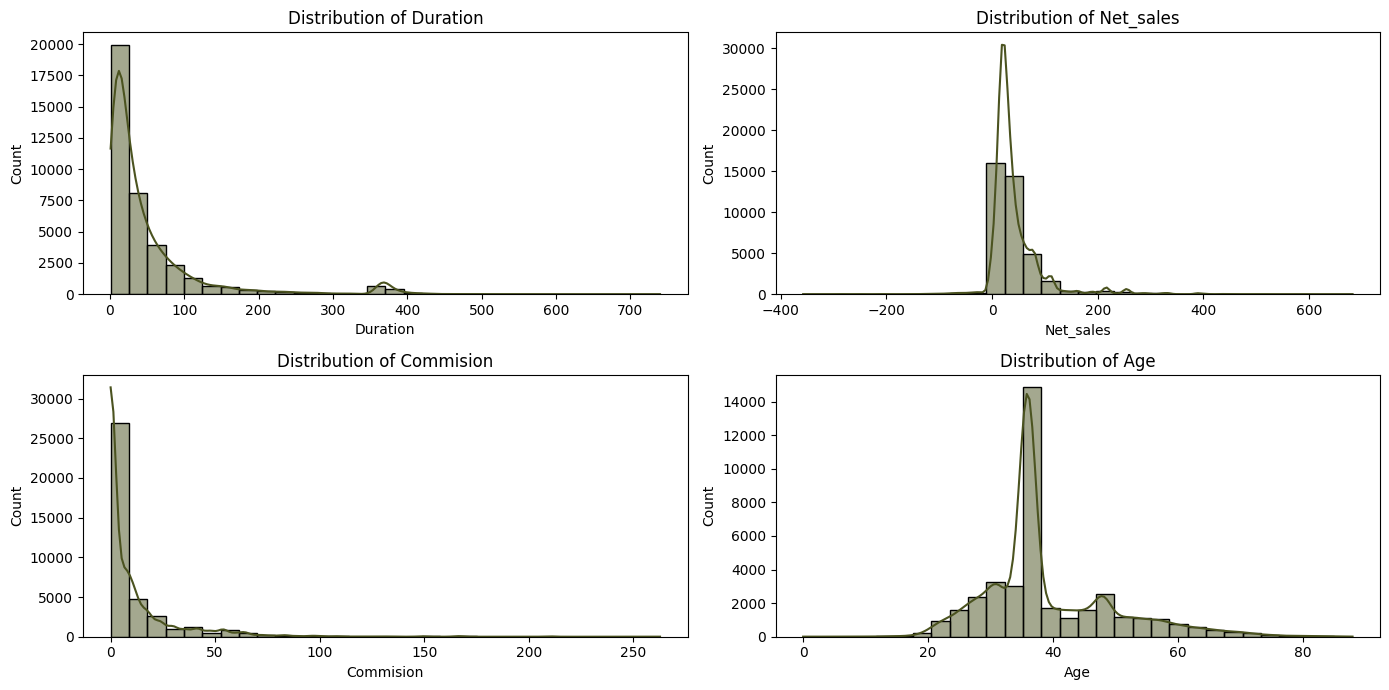

In [69]:
num_cols = df.select_dtypes(include='number').drop(columns=['Claim']).columns
fig, axes = plt.subplots(2, 2, figsize=(14, 7))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

- **Categorical Features**

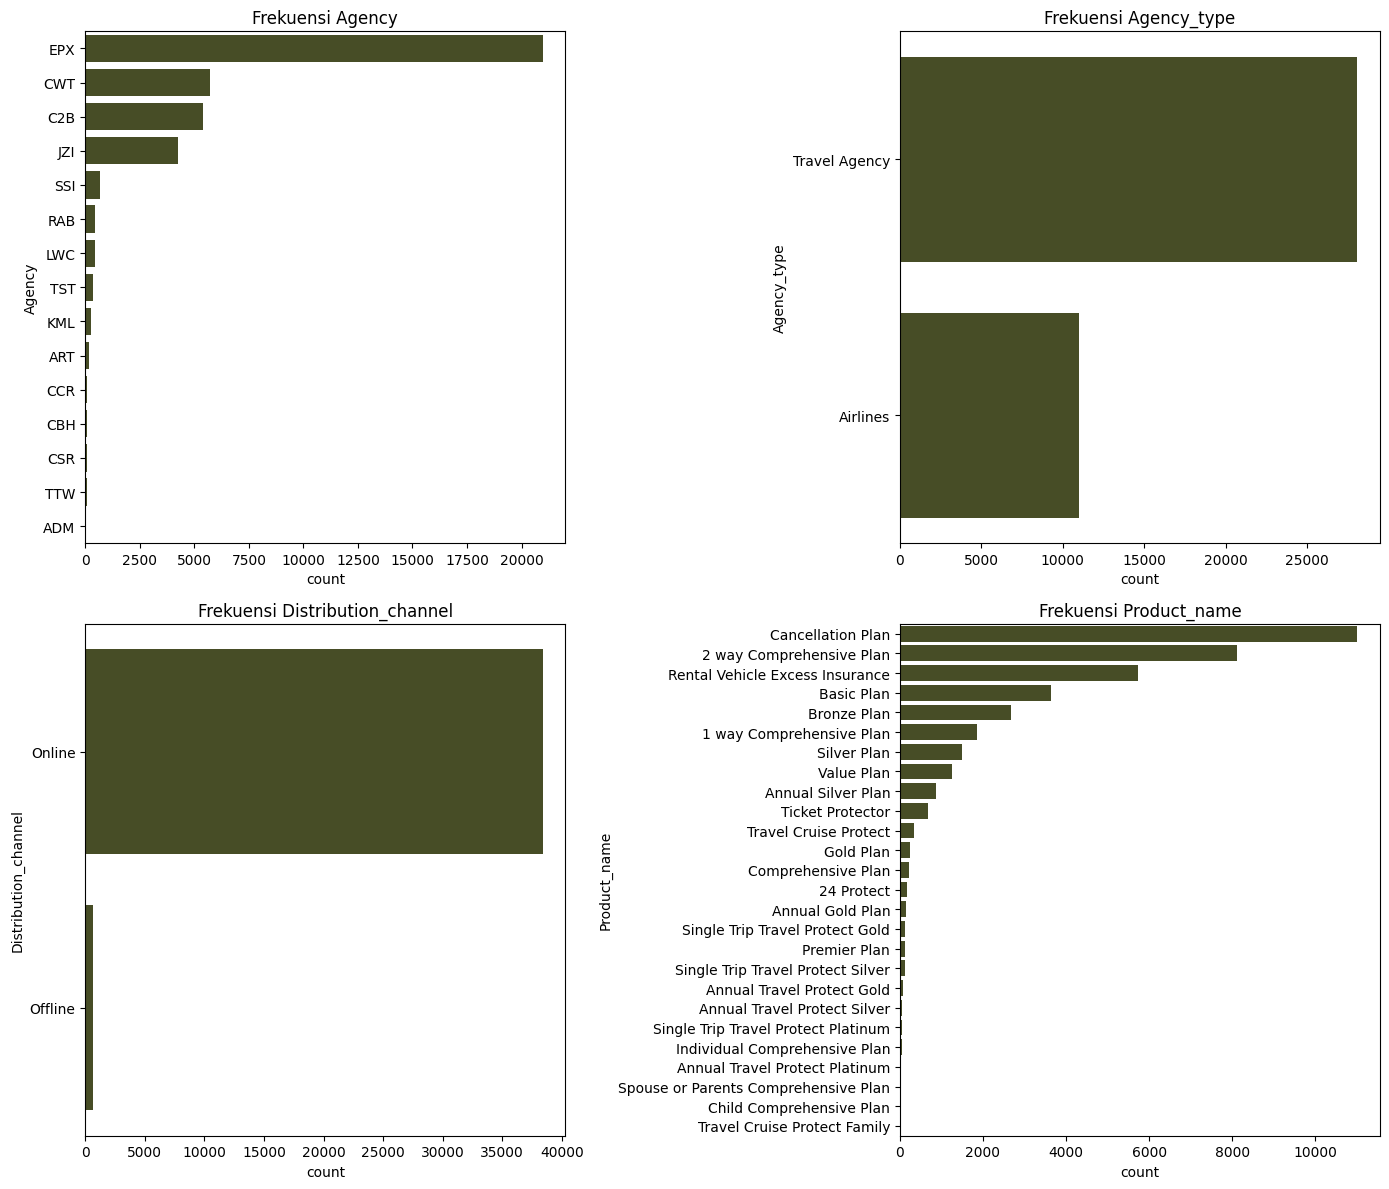

In [70]:
cat_cols = df.select_dtypes(include="object").drop(columns=["Destination"]).columns
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(y=df[col], order=df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f"Frekuensi {col}")
plt.tight_layout()
plt.show()

<Axes: xlabel='count', ylabel='Destination'>

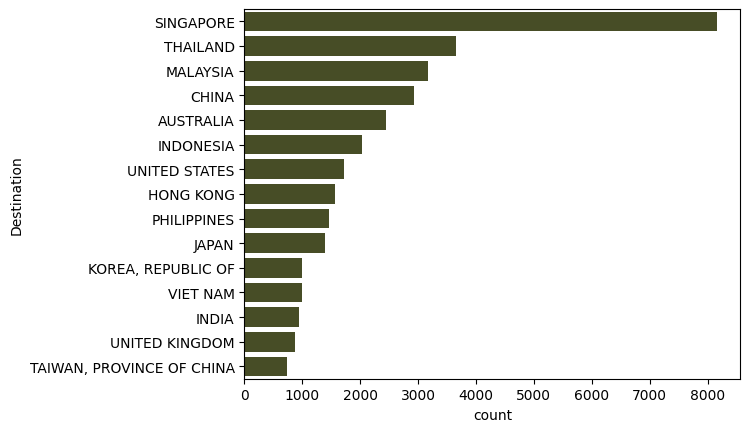

In [71]:
# for destination feature, only top 15 is shown
destination_top_15 = df['Destination'].value_counts().nlargest(15)
sns.countplot(y=df[df['Destination'].isin(destination_top_15.index)]['Destination'], order=destination_top_15.index)

**Findings**

`Duration`, `Net_sales`, and `Commision` all have skewed distributions and strong outliers

`Agency` : The majority of transactions come from EPX, followed by CWT and C2B. Other agencies contribute very little in comparison.

`Agency_type` : Most records are from Travel Agencies, while Airlines account for a much smaller share.

`Distribution_channel` : The dataset is heavily dominated by the Online channel, with Offline almost negligible.

`Product_name` : The most frequent products are Cancellation Plan, 2-way Comprehensive Plan, and Cancellation plan Insurance. Many other products appear far less frequently.

`Gender` : Distribution between Male (M) and Female (F) is relatively balanced. However, it's not representing all the data because around 70% is not recorded

`Destination` : Countries in Southeast Asia remain the favorite destinations to visit

### **Relationship Between Features**

- **Numerical Correlation**

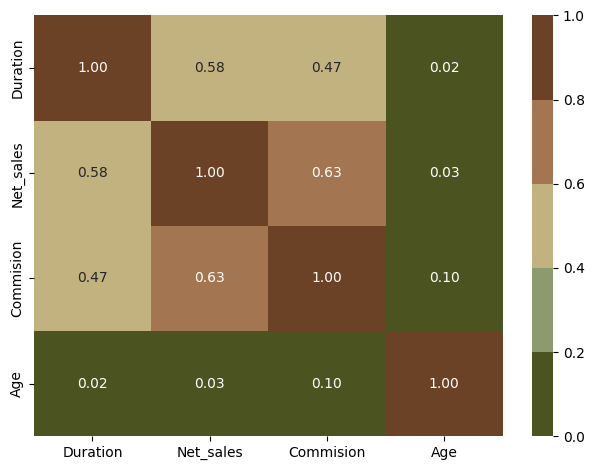

In [72]:
earth_cmap = ListedColormap(["#4B5320","#8C9A6D","#C2B280","#A47551","#6B4226"])

sns.heatmap(
    df.select_dtypes(include='number').drop(columns=['Claim']).corr(),
    annot=True,
    cmap=earth_cmap,
    vmin=0,
    vmax=1.0,
    fmt=".2f"
)
plt.tight_layout()
plt.show()

- **Scatter between 2 numerical features**

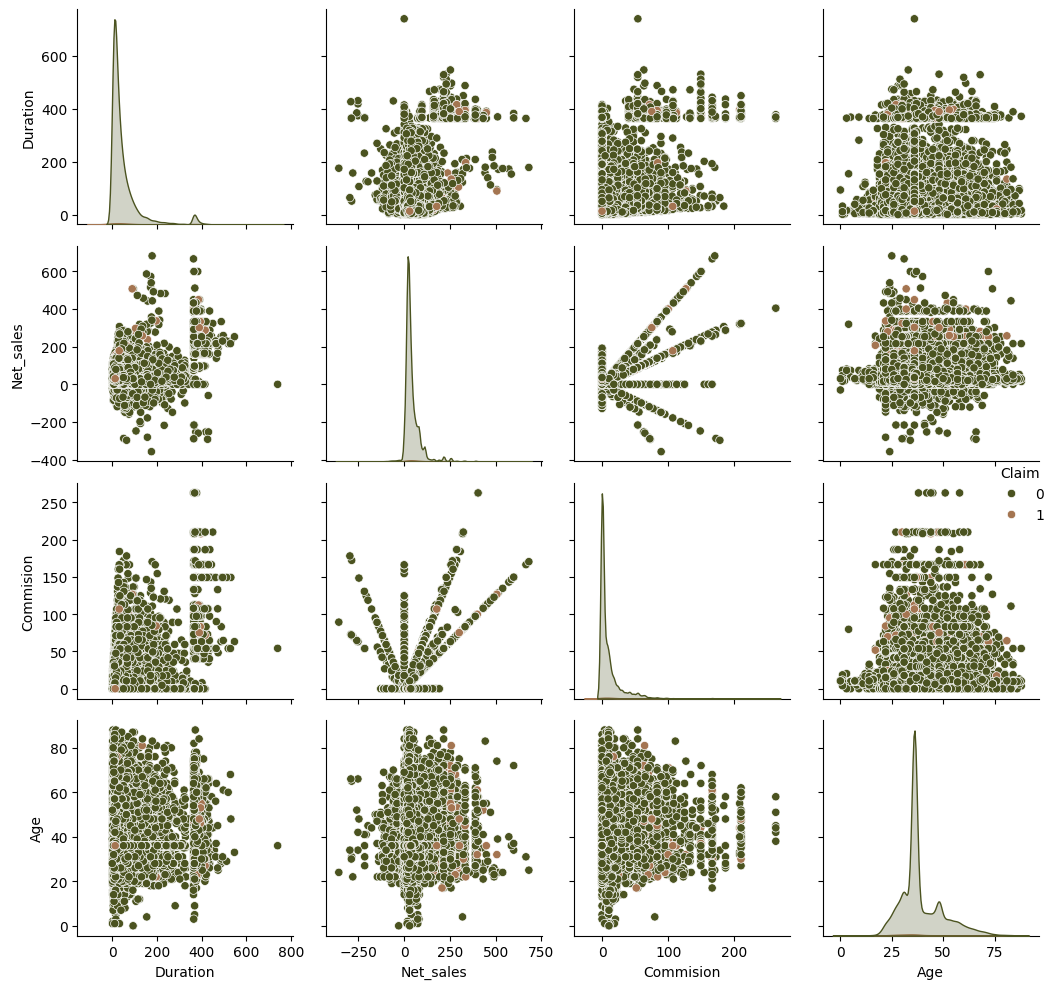

In [73]:
sns.pairplot(df, hue='Claim')
plt.tight_layout()

**Findings**

`Net_sales` and `Commision` have a relatively strong relationship (0.64), which means that higher commission tends to be associated with higher net sales

`Duration` and `Commision` have week to moderate relationship but still sowhing some influence

`Age` have very low correlation with all features, meaning that customer age is not directly relation

### **Target Feature**

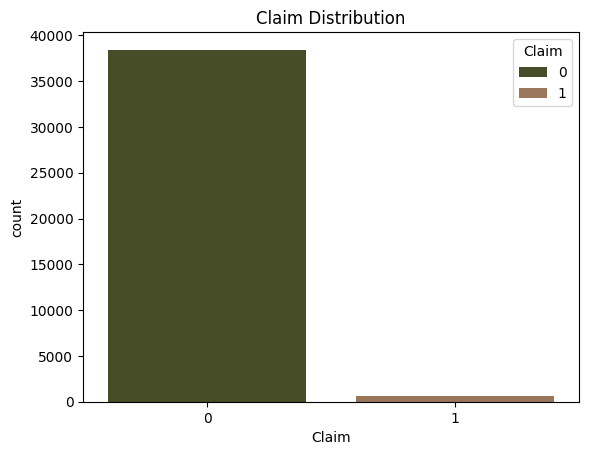

Claim
0    0.983922
1    0.016078
Name: proportion, dtype: float64


In [74]:
sns.countplot(x=df['Claim'], hue=df['Claim'])
plt.title("Claim Distribution")
plt.show()

print(df['Claim'].value_counts(normalize=True))


**Findings**

The target (`Claim`) is highly imbalanced

The ratio is approximatetly **61:1** 

An imbalance indicates that the dataset is dominated by non-claim. Without proper handling (e.g., SMOTE, undersampling, class weights), ML models may become biased

### **Relationship againts the target**

- **Numerical Features**

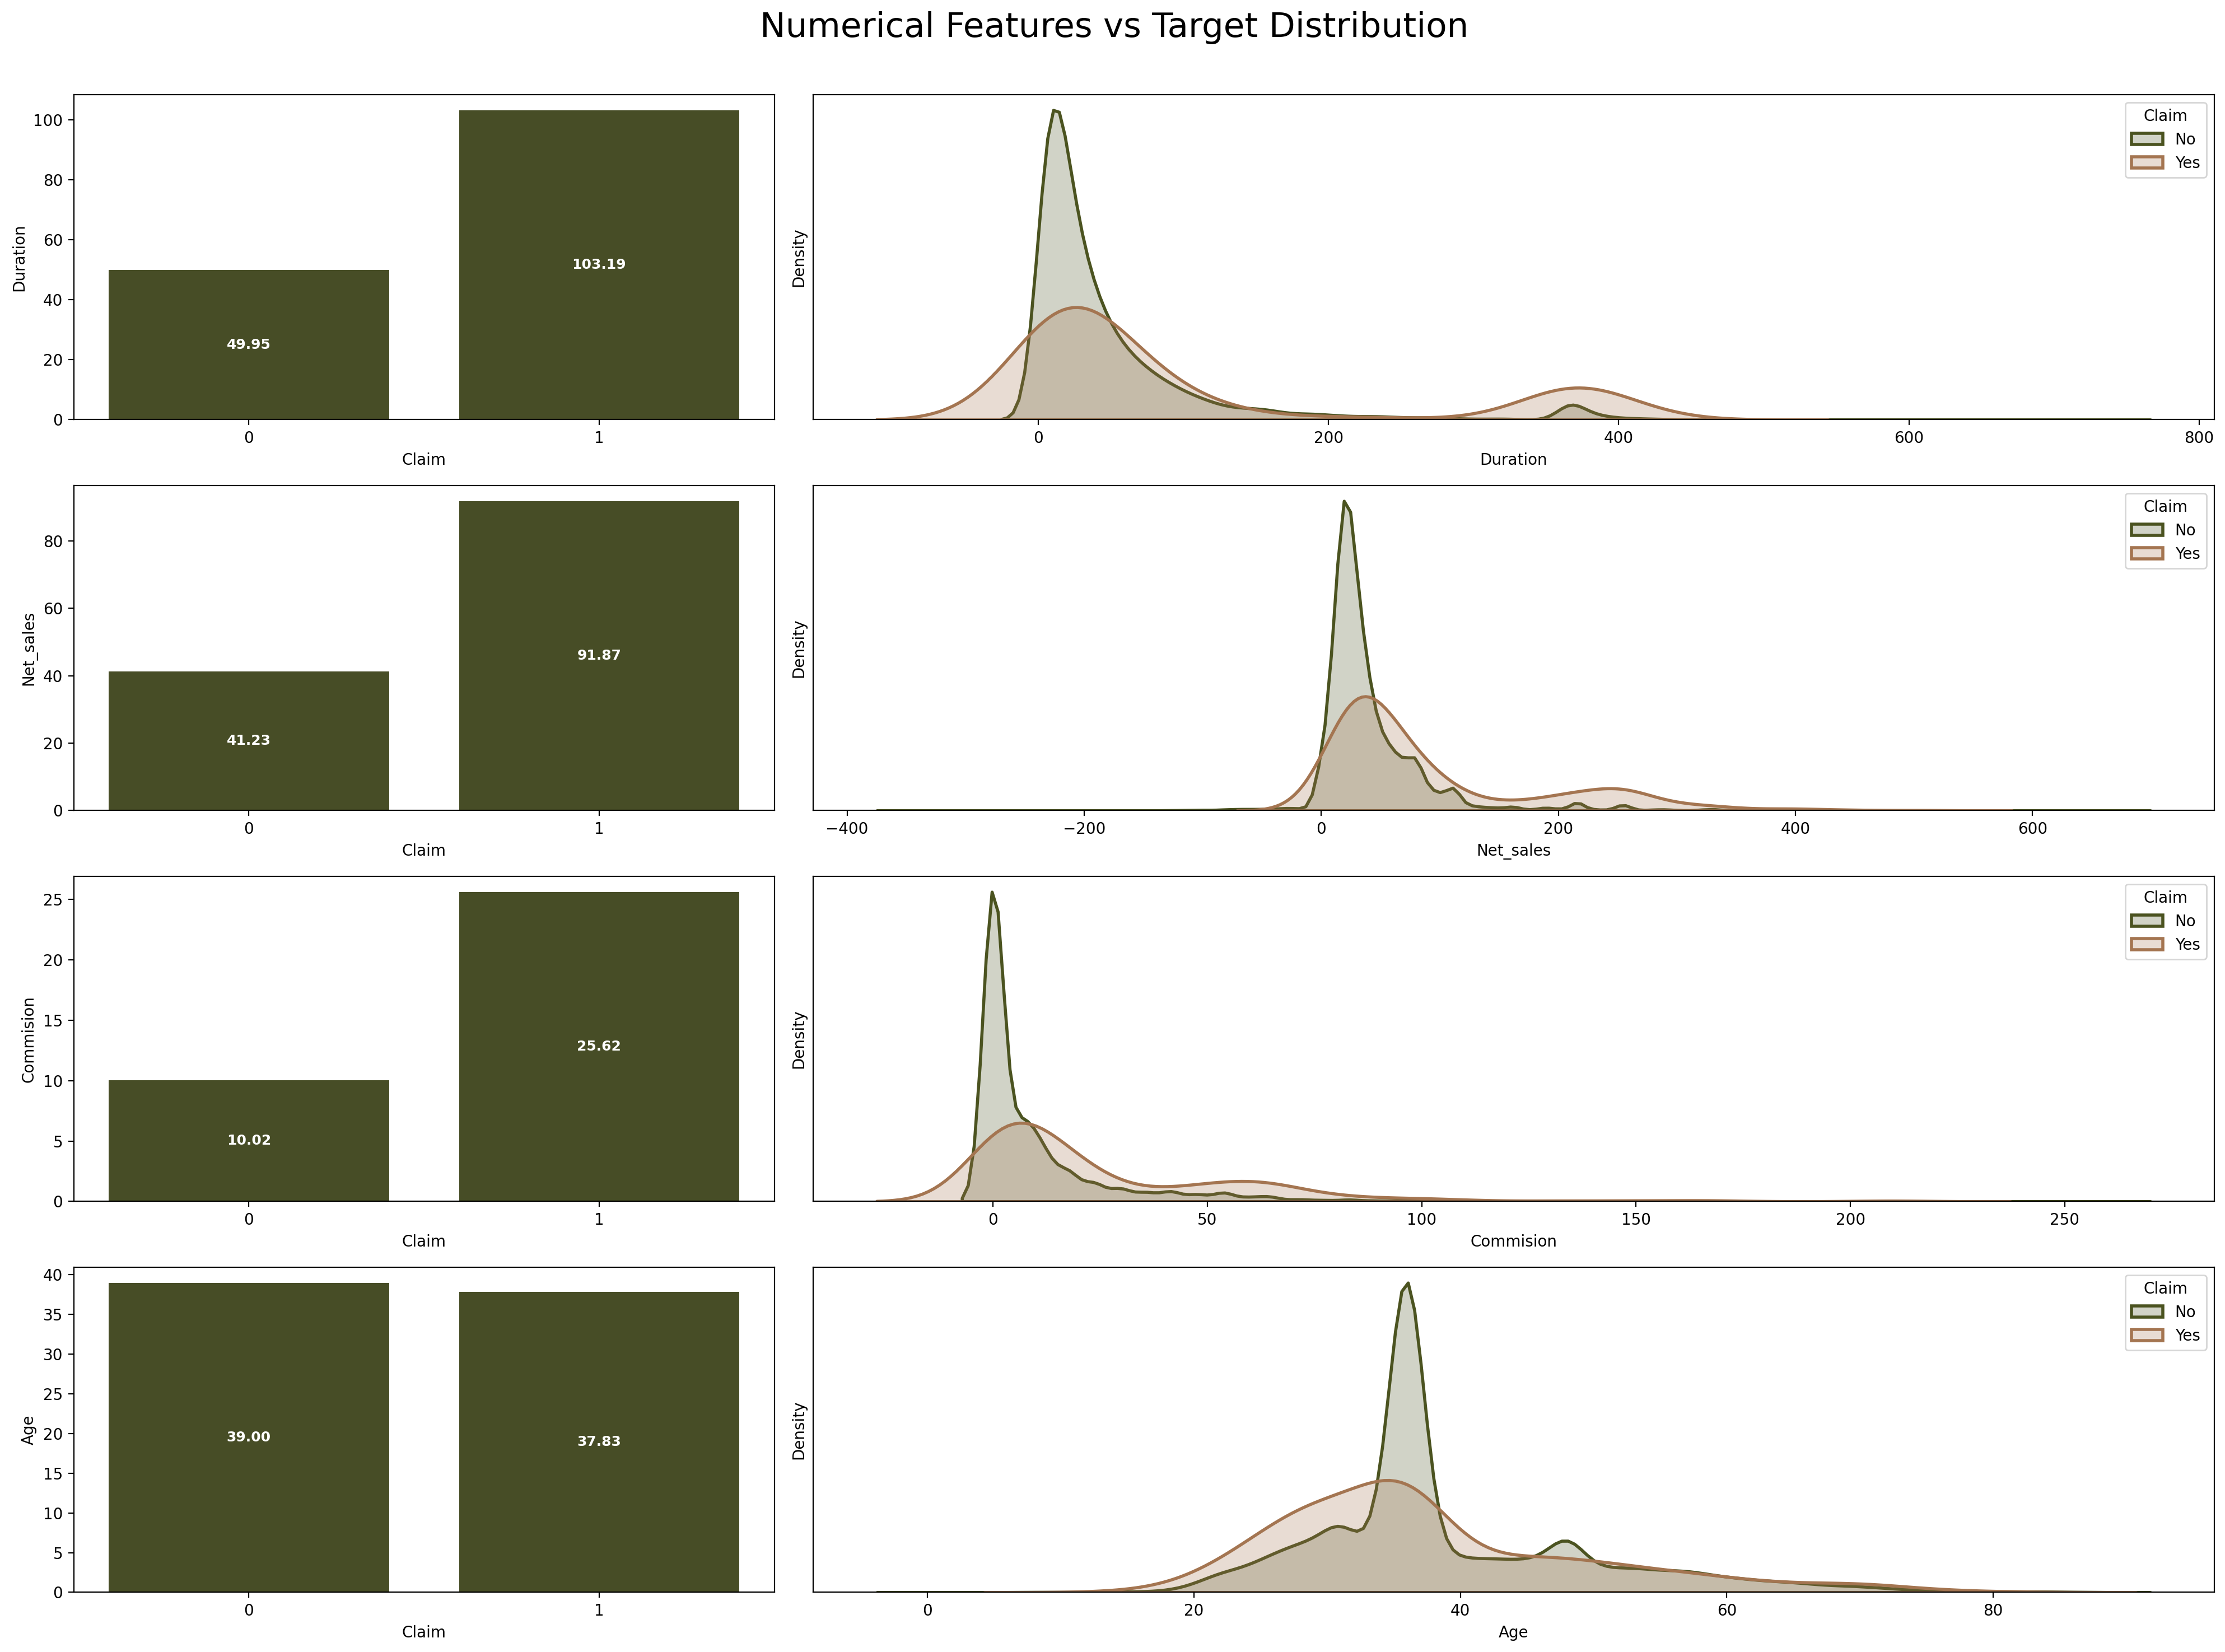

In [75]:
sns.set_palette(['#4B5320', '#A47551'])

fig, ax = plt.subplots(4, 2, figsize=(20,15), dpi=200, gridspec_kw={'width_ratios': [1, 2]})
for i, col in enumerate(num_cols):
    # Barplot
    graph = sns.barplot(data=df, x='Claim', y=col, ax=ax[i,0], errorbar=None)

    #label
    for cont in graph.containers:
        graph.bar_label(
            cont, 
            fmt='%.2f', 
            label_type='center',
            color='white',
            fontsize=9, 
            fontweight='bold'
        )
    
    # KDE plot
    sns.kdeplot(data=df[df['Claim']==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='No')
    sns.kdeplot(data=df[df['Claim']==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='Yes')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Claim', loc='upper right')

plt.suptitle('Numerical Features vs Target Distribution', fontsize=22)
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()

- **Categorical Features**

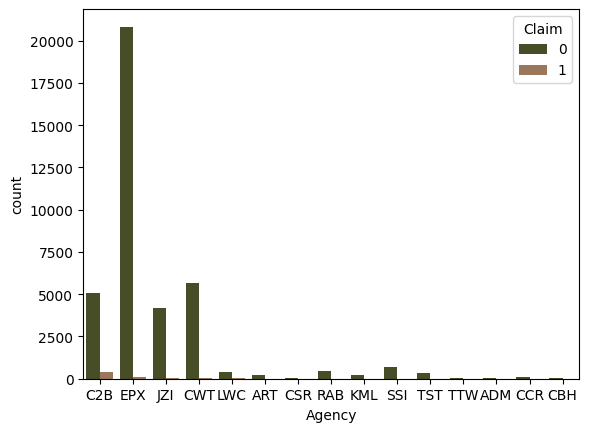

Claim,0,1
Agency,,
C2B,5049,369
EPX,20830,131
CWT,5659,64
LWC,422,29
JZI,4208,20
SSI,675,5
KML,242,3
TST,341,2
CBH,68,1


In [76]:
sns.countplot(data=df, x='Agency', hue='Claim')
plt.show()
pd.crosstab(df['Agency'], df['Claim']).sort_values(by=1, ascending=False).head(10)

In [77]:
df['Agency'].value_counts()

Agency
EPX    20961
CWT     5723
C2B     5418
JZI     4228
SSI      680
RAB      466
LWC      451
TST      343
KML      245
ART      192
CCR       96
CBH       69
CSR       68
TTW       66
ADM       54
Name: count, dtype: int64

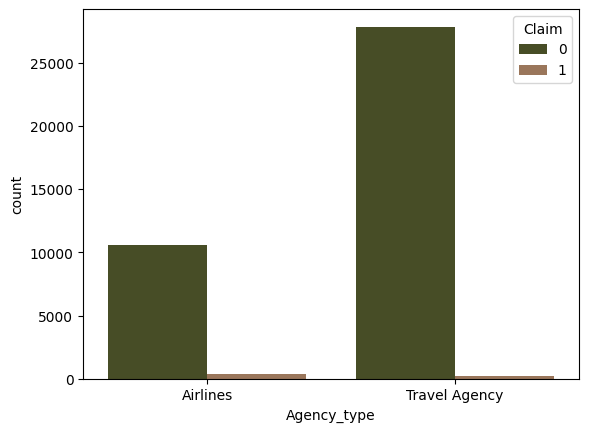

Claim,0,1
Agency_type,,
Airlines,10589,395
Travel Agency,27843,233


In [78]:
sns.countplot(data=df, x='Agency_type', hue='Claim')    
plt.show()
pd.crosstab(df['Agency_type'], df['Claim'])

In [79]:
df.columns

Index(['Agency', 'Agency_type', 'Distribution_channel', 'Product_name',
       'Duration', 'Destination', 'Net_sales', 'Commision', 'Age', 'Claim'],
      dtype='object')

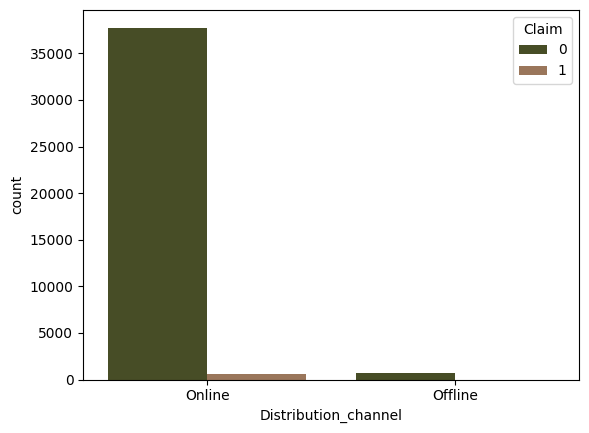

Claim,0,1
Distribution_channel,,
Offline,664,8
Online,37768,620


In [80]:
sns.countplot(data=df, x='Distribution_channel', hue='Claim')    
plt.show()
pd.crosstab(df['Distribution_channel'], df['Claim'])

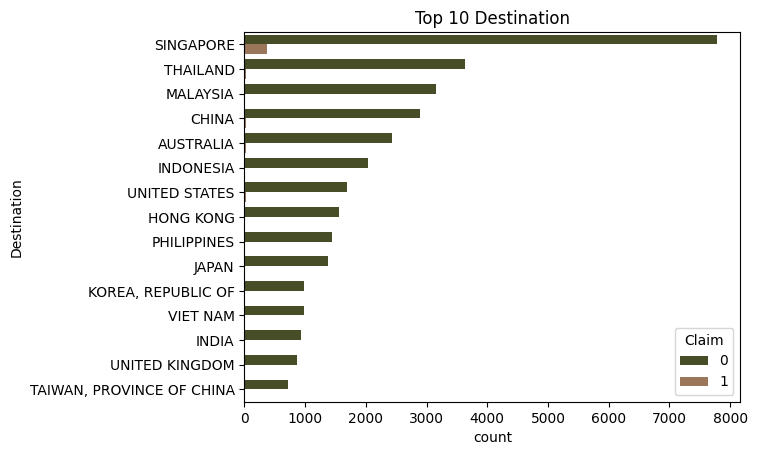

Claim,0,1
Destination,,
SINGAPORE,7779,379
THAILAND,3637,23
MALAYSIA,3157,16
CHINA,2894,30
AUSTRALIA,2423,29
INDONESIA,2028,8
UNITED STATES,1690,29
HONG KONG,1555,8
PHILIPPINES,1448,6


In [82]:
destination_top_15 = df['Destination'].value_counts().nlargest(15)
sns.countplot(
    y=df[df['Destination'].isin(destination_top_15.index)]['Destination'],
    order=destination_top_15.index,
    hue=df['Claim'])
plt.title('Top 10 Destination')
plt.show()

pd.crosstab(df['Destination'], df['Claim']).sort_values(0, ascending=False).head(10)

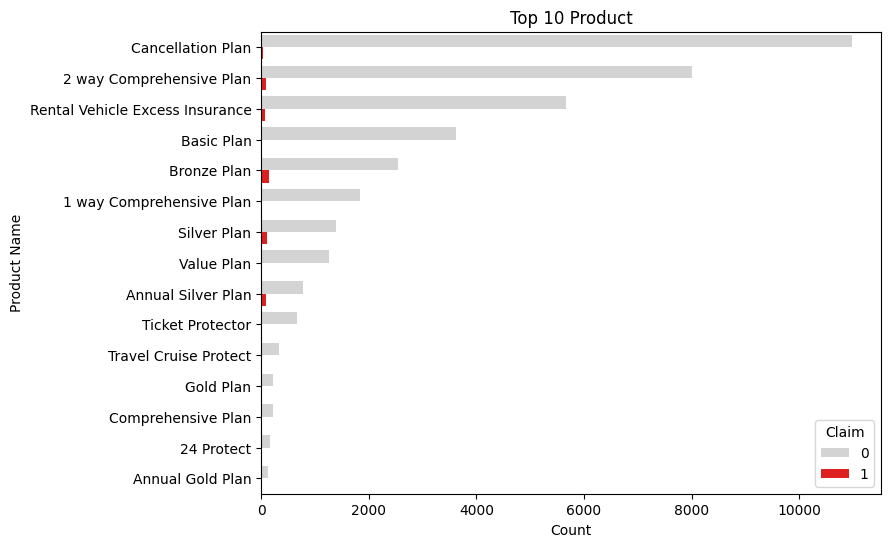

Claim                                0    1
Product_name                               
Bronze Plan                       2539  146
Silver Plan                       1393  105
2 way Comprehensive Plan          8015   94
Annual Silver Plan                 772   91
Rental Vehicle Excess Insurance   5659   64
Cancellation Plan                10976   31
Annual Gold Plan                   121   15
Basic Plan                        3627   14
Gold Plan                          224   12
Value Plan                        1253    8


In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

product_top_15 = df['Product_name'].value_counts().nlargest(15)

# Filter data hanya top 15 produk
df_top = df[df['Product_name'].isin(product_top_15.index)]

# Definisikan warna: 0 = abu muda, 1 = merah
palette = {0: "lightgrey", 1: "red"}

plt.figure(figsize=(8,6))
sns.countplot(
    y=df_top['Product_name'],
    order=product_top_15.index,
    hue=df_top['Claim'],
    palette=palette
)
plt.title('Top 10 Product')
plt.xlabel("Count")
plt.ylabel("Product Name")
plt.legend(title="Claim")
plt.show()

# Crosstab untuk distribusi Claim per produk
print(pd.crosstab(df['Product_name'], df['Claim']).sort_values(1, ascending=False).head(10))

**Summary**
 
- None of the numerical variables shows a strong distinguishing pattern between “Yes” and “No” claims, the imbalance is visible everywhere.
- The EPX `agency` had the highest sales volume with 20,961 policies sold but only 131 claims filed. Conversely, C2B demonstrated the worst performance; out of just 4059 sales, it had the highest number of claims at approximately 369.
- Travel Agencies is `Agency_type` which had the highest sales volume with 28076 policies sold but only 233 claims filed. Conversely, Airlines demonstrated a higher claim risk; out of just 10984 sales, they had a higher number of claims at 395.
- The `Distribution_channel` shows online channel drives the vast majority of sales, about 98%
- Singapore becomes the most popular `Destination` to visit. from 7779 policyholder who made travel to singapore 379 of them clain the insurance
- the most insurance `Product` to buy is cancellation plan. from 11007 sales merely 31 claims filed

## **5. Data Preparation for Modeling**

### **Define X and y**

In [86]:
X = df.drop(columns='Claim')
y = df['Claim']
display(X.head(), y.head())

,Agency,Agency_type,Distribution_channel,Product_name,Duration,Destination,Net_sales,Commision,Age
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.0,57
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.0,33
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.7,26
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.0,59
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.0,28


0    0
1    0
2    0
3    0
4    0
Name: Claim, dtype: int64

### **Train Test Split**

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## **6. Data Preprocessing**

In [88]:
num_cols = ['Duration', 'Net_sales', 'Commision', 'Age']
onehot_cols = ['Agency_type', 'Distribution_channel']
binary_cols = ['Agency', 'Product_name', 'Destination']

# Numerical pipeline
numerical_pipeline = Pipeline([
    ('scaler', RobustScaler())
])

# Other categoricals (no imputer needed)
onehot_pipeline = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
binary_pipeline = BinaryEncoder()

# Combine into one "categorical pipeline"
categorical_pipeline = ColumnTransformer([
    ('onehot', onehot_pipeline, onehot_cols),
    ('binary', binary_pipeline, binary_cols)
], verbose_feature_names_out=False)

# Final preprocessor
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, num_cols),
    ('cat', categorical_pipeline, onehot_cols + binary_cols)
], verbose_feature_names_out=False).set_output(transform='pandas')

preprocessor


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"


In [89]:
preprocessor.fit_transform(X_train)

,Duration,Net_sales,Commision,Age,Agency_type_Travel Agency,Distribution_channel_Online,Agency_0,Agency_1,Agency_2,Agency_3,...,Product_name_3,Product_name_4,Destination_0,Destination_1,Destination_2,Destination_3,Destination_4,Destination_5,Destination_6,Destination_7
23837,-0.304348,-0.393443,0.000000,0.0,1.0,1.0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
29773,-0.326087,0.000000,0.000000,0.0,1.0,1.0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
21850,-0.152174,-0.196721,0.000000,0.0,1.0,1.0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
5083,-0.500000,-0.163934,0.000000,0.0,1.0,1.0,0,0,0,1,...,1,1,0,0,0,0,0,0,1,1
10518,-0.521739,-0.196721,0.648148,-0.4,0.0,1.0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38518,-0.478261,-0.163934,0.000000,0.6,1.0,1.0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,1
35665,0.413043,-0.262295,0.000000,0.0,1.0,1.0,0,0,0,1,...,1,1,0,0,0,1,0,1,0,0
3875,0.304348,-0.180328,0.473906,0.0,0.0,1.0,0,1,0,0,...,1,1,0,0,0,0,1,0,1,1
5429,-0.456522,0.000000,0.000000,1.3,1.0,1.0,0,0,0,1,...,0,1,0,0,0,0,0,1,1,0


## **7. Model Selection**

### Model Selection with Default Config

In [90]:
df['Claim'].value_counts()

Claim
0    38432
1      628
Name: count, dtype: int64

In [91]:
# Individual model list with imbalance adjustment
# Base models
logistic = LogisticRegression(random_state=0)
dtree = DecisionTreeClassifier(random_state=0)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=0)
xgb = XGBClassifier(random_state=0) 
gb = GradientBoostingClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0)

In [92]:
list_model = [logistic, dtree, knn, rf, xgb, gb, lgbm]

list_f2_all = []  
list_f2_mean = []
list_f2_std = []

list_recall_all = []
list_recall_mean = []
list_recall_std = []

list_precision_all = []
list_precision_mean = []
list_precision_std = []

list_model_name = []

# stratified CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

for model in list_model:
    pipe_model = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("model", model)
    ])
    
    
    # f2 score
    f2_scorer = make_scorer(fbeta_score, beta=2)
    f2_scores = cross_val_score(pipe_model, X_train, y_train, cv=cv, scoring=f2_scorer, n_jobs=-1)
    # list_f2_all.append(f2_scores)
    list_f2_mean.append(f2_scores.mean())
    list_f2_std.append(f2_scores.std())
    
    # recall
    recall_scores = cross_val_score(pipe_model, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1)
    # list_recall_all.append(recall_scores)
    list_recall_mean.append(recall_scores.mean())
    list_recall_std.append(recall_scores.std())
    
    # precision
    precision_scores = cross_val_score(pipe_model, X_train, y_train, cv=cv, scoring='precision', n_jobs=-1)
    # list_precision_all.append(precision_scores)
    list_precision_mean.append(precision_scores.mean())
    list_precision_std.append(precision_scores.std())

    list_model_name.append(model.__class__.__name__)

df_cv = pd.DataFrame({
    'model': list_model_name,
    'f2_mean': list_f2_mean,
    'f2_std': list_f2_std,
    'recall_mean': list_recall_mean,
    'recall_std': list_recall_std,
    'precision_mean': list_precision_mean,
    'precision_std': list_precision_std
})
df_cv.sort_values(by='recall_mean', ascending=False)

,model,f2_mean,f2_std,recall_mean,recall_std,precision_mean,precision_std
1,DecisionTreeClassifier,0.066853,0.039444,0.071686,0.042991,0.053252,0.030762
3,RandomForestClassifier,0.021489,0.016647,0.017922,0.013878,0.112937,0.089585
2,KNeighborsClassifier,0.004915,0.009830,0.004000,0.008000,0.116667,0.298608
5,GradientBoostingClassifier,0.004950,0.009901,0.004000,0.008000,0.100000,0.200000
6,LGBMClassifier,0.004903,0.009807,0.003961,0.007922,0.133333,0.305505
4,XGBClassifier,0.002404,0.007212,0.001961,0.005882,0.025000,0.075000
0,LogisticRegression,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Model Selection with Class Weight

In [93]:
pos_class_weight = (y_train==0).sum() / (y_train==1).sum() # Initial guess
pos_class_weight

np.float64(61.24701195219124)

In [94]:
logistic = LogisticRegression(random_state=0, class_weight='balanced')
dtree = DecisionTreeClassifier(random_state=0, class_weight='balanced')
rf = RandomForestClassifier(random_state=0, class_weight='balanced')
xgb = XGBClassifier(random_state=0, scale_pos_weight=pos_class_weight)
lgbm = LGBMClassifier(random_state=0, class_weight='balanced')

In [95]:
list_model = [logistic, dtree, rf, xgb, lgbm]
 
list_f2_mean = []
list_f2_std = []

list_recall_mean = []
list_recall_std = []

list_precision_mean = []
list_precision_std = []

list_model_name = []

# stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for model in list_model:
    pipe_model = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("model", model)
    ])
    
    
    # f2 score
    f2_scorer = make_scorer(fbeta_score, beta=2)
    f2_scores = cross_val_score(pipe_model, X_train, y_train, cv=cv, scoring=f2_scorer, n_jobs=-1)
    list_f2_mean.append(f2_scores.mean())
    list_f2_std.append(f2_scores.std())
    
    # recall
    recall_scores = cross_val_score(pipe_model, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1)
    list_recall_mean.append(recall_scores.mean())
    list_recall_std.append(recall_scores.std())
    
    # precision
    precision_scores = cross_val_score(pipe_model, X_train, y_train, cv=cv, scoring='precision', n_jobs=-1)
    list_precision_mean.append(precision_scores.mean())
    list_precision_std.append(precision_scores.std())

    list_model_name.append(model.__class__.__name__)

df_cv = pd.DataFrame({
    'model': list_model_name,
    'f2_mean': list_f2_mean,
    'f2_std': list_f2_std,
    'recall_mean': list_recall_mean,
    'recall_std': list_recall_std,
    'precision_mean': list_precision_mean,
    'precision_std': list_precision_std
})
df_cv.sort_values(by='recall_mean', ascending=False)

,model,f2_mean,f2_std,recall_mean,recall_std,precision_mean,precision_std
0,LogisticRegression,0.201869,0.013496,0.681347,0.033883,0.052970,0.004128
4,LGBMClassifier,0.211006,0.012439,0.486079,0.029544,0.064736,0.004456
3,XGBClassifier,0.177376,0.032118,0.273030,0.053370,0.073927,0.012276
1,DecisionTreeClassifier,0.069177,0.016300,0.069703,0.016500,0.067207,0.015637
2,RandomForestClassifier,0.009639,0.008985,0.007960,0.007420,0.061722,0.057736


### Model Selection with Resampling

In [96]:
logistic = LogisticRegression(random_state=0)
dtree = DecisionTreeClassifier(random_state=0)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=0)
xgb = XGBClassifier(random_state=0) 
gb = GradientBoostingClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0)

ros = RandomOverSampler(random_state=0)
smote = SMOTE(random_state=0)
rus = RandomUnderSampler(random_state=0)

list_model = [logistic, dtree, rf, xgb, lgbm]
list_resampler = [
    ("RandomOverSampler", ros),
    ("SMOTE", smote),
    ("RandomUnderSampler", rus),
]
 
list_f2_mean = []
list_f2_std = []

list_recall_mean = []
list_recall_std = []

list_precision_mean = []
list_precision_std = []

list_model_name = []
list_resampler_name = []

# stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for model in list_model:
    for res_name, resampler in list_resampler:
        pipe_model = ImbPipeline(steps=[
            ("preprocessing", preprocessor),
            ("resampler", resampler),
            ("model", model)
        ])
        
        # f2 score
        f2_scorer = make_scorer(fbeta_score, beta=2)
        f2_scores = cross_val_score(pipe_model, X_train, y_train, cv=cv, scoring=f2_scorer, n_jobs=-1)
        list_f2_mean.append(f2_scores.mean())
        list_f2_std.append(f2_scores.std())
        
        # recall
        recall_scores = cross_val_score(pipe_model, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1)
        list_recall_mean.append(recall_scores.mean())
        list_recall_std.append(recall_scores.std())
        
        # precision
        precision_scores = cross_val_score(pipe_model, X_train, y_train, cv=cv, scoring='precision', n_jobs=-1)
        list_precision_mean.append(precision_scores.mean())
        list_precision_std.append(precision_scores.std())

        list_model_name.append(model.__class__.__name__)
        list_resampler_name.append(res_name)

df_cv = pd.DataFrame({
    'model': list_model_name,
    'resampler': list_resampler_name,
    'f2_mean': list_f2_mean,
    'f2_std': list_f2_std,
    'recall_mean': list_recall_mean,
    'recall_std': list_recall_std,
    'precision_mean': list_precision_mean,
    'precision_std': list_precision_std
})

df_cv.sort_values('recall_mean', ascending= False)

,model,resampler,f2_mean,f2_std,recall_mean,recall_std,precision_mean,precision_std
14,LGBMClassifier,RandomUnderSampler,0.161426,0.006356,0.711208,0.026911,0.039462,0.001728
8,RandomForestClassifier,RandomUnderSampler,0.169638,0.011722,0.705168,0.039327,0.042041,0.003230
11,XGBClassifier,RandomUnderSampler,0.154260,0.005877,0.701287,0.032380,0.037445,0.001409
2,LogisticRegression,RandomUnderSampler,0.191519,0.018819,0.695208,0.027328,0.049283,0.005928
0,LogisticRegression,RandomOverSampler,0.201642,0.014059,0.681347,0.035610,0.052886,0.004223
1,LogisticRegression,SMOTE,0.186706,0.023174,0.667366,0.049749,0.048180,0.006721
5,DecisionTreeClassifier,RandomUnderSampler,0.125297,0.010806,0.649465,0.047264,0.029645,0.002679
12,LGBMClassifier,RandomOverSampler,0.205676,0.011477,0.470139,0.023356,0.063319,0.004027
13,LGBMClassifier,SMOTE,0.170433,0.027746,0.269050,0.035935,0.069304,0.013454
10,XGBClassifier,SMOTE,0.164023,0.018351,0.250990,0.024692,0.068986,0.009425


**Findings**
- to define the model which will be used for further modeling, model selection use several scenario which are using default parameter for each algorithm, using weigh_balance parameter and resampling method
- in default configuration scenario, it shows that decisiotree and random forest are the highest recall, however since the data is severly imbalance the data from this configuration is not adequate
- second scnario, is implementing weigh_class parameter and shows LogisticRegression has highesat recall (0.681347) followed by LGBMClassfier and XGBoost
- last scenario, using resampling method shows the top four recall are LGBMClassifier, RandomForest, XGBCLassifier and LogisticRegression under RandomUnderSampling method. however, it doesnt result significance different compared to second scenario even in some algorithm, weight_class parameter gives better result
- based on model selection, LogisticRegression, LGBMClassifier and XGBoost will be choosen and used for the next step

## **8. Hyperparameter Tuning**

### Tuning GridSearch - LogisticRegression

In [97]:
pipe_base_log = Pipeline([
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(random_state=0, class_weight='balanced'))
]
)

pipe_base_log.fit(X_train, y_train)

y_train_base = pipe_base_log.predict(X_train)
y_test_base = pipe_base_log.predict(X_test)


recall_train_base = recall_score(y_train, y_train_base)
recall_test_base = recall_score(y_test, y_test_base)

print(f"Train recall (Base Model): {recall_train_base:.4f}")
print(f"Test recall (Base Model): {recall_test_base:.4f}")

c:\Users\nreva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train recall (Base Model): 0.6932
Test recall (Base Model): 0.7540


In [98]:
hyperparams = {
    'model__C': [0.0001, 0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'saga'],
    'model__max_iter': [100, 200, 300],
    'model__penalty': ['l1', 'l2'],
    'model__class_weight': [None, 'balanced']
}

In [99]:
gridsearch = GridSearchCV(
    estimator=pipe_base_log,
    param_grid=hyperparams,
    scoring='recall', 
    cv=5,
    n_jobs=-1,
    verbose=1,
    error_score=np.nan
)

gridsearch

,estimator,Pipeline(step...om_state=0))])
,param_grid,"{'model__C': [0.0001, 0.01, ...], 'model__class_weight': [None, 'balanced'], 'model__max_iter': [100, 200, ...], 'model__penalty': ['l1', 'l2'], ...}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [100]:
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\nreva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,estimator,Pipeline(step...om_state=0))])
,param_grid,"{'model__C': [0.0001, 0.01, ...], 'model__class_weight': [None, 'balanced'], 'model__max_iter': [100, 200, ...], 'model__penalty': ['l1', 'l2'], ...}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [101]:
gridsearch.best_score_

np.float64(0.7270693069306932)

In [102]:
gridsearch.best_params_

{'model__C': 0.1,
 'model__class_weight': 'balanced',
 'model__max_iter': 100,
 'model__penalty': 'l2',
 'model__solver': 'saga'}

In [103]:
best_model_log = gridsearch.best_estimator_
best_model_log

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [104]:
# Evaluate best model

# Fitting tuned model
best_model_log.fit(X_train, y_train)

# Cek recall tuned model di train dan test
y_train_tuned_log = best_model_log.predict(X_train)
y_test_tuned_log = best_model_log.predict(X_test)

recall_train_tuned = recall_score(y_train, y_train_tuned_log)
recall_test_tuned = recall_score(y_test, y_test_tuned_log)

print('Evaluation Model: LogisticRegression')
print(f"Train Recall (Tuned Model): {recall_train_tuned:.4f}")
print(f"Test Recall (Tuned Model): {recall_test_tuned:.4f}")

c:\Users\nreva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Evaluation Model: LogisticRegression
Train Recall (Tuned Model): 0.7131
Test Recall (Tuned Model): 0.8095


In [105]:
y_pred_base = best_model_log.predict(X_test)

conf_matrix_before = confusion_matrix(y_test, y_test_base)
conf_matrix_after_log = confusion_matrix(y_test, y_test_tuned_log)

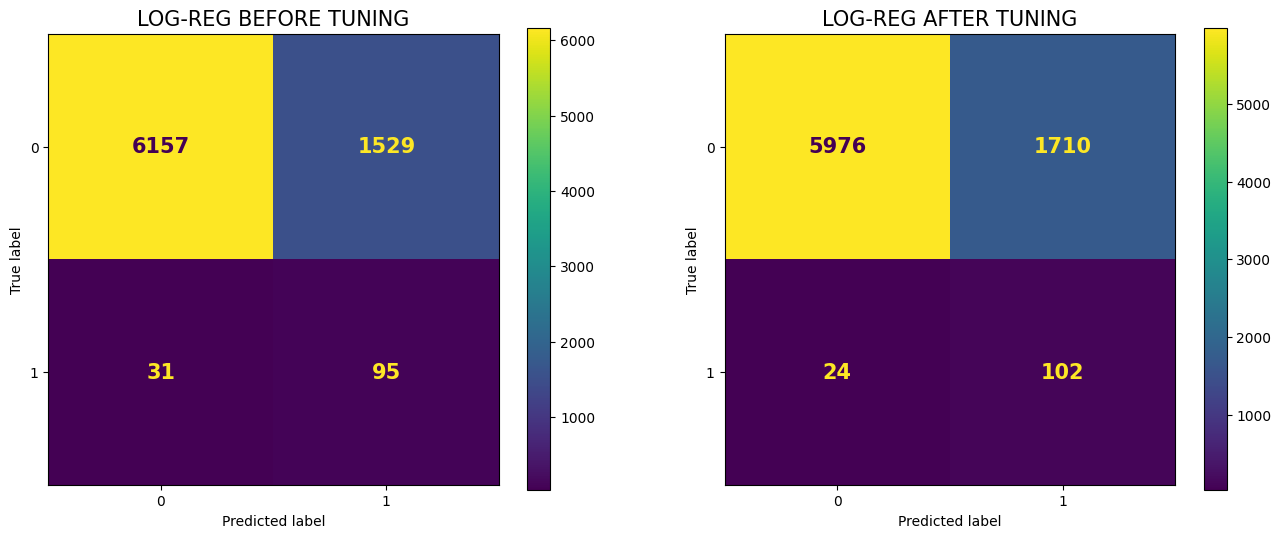

In [106]:
figure, axes = plt.subplots(ncols=2, figsize=(16,6))

text_format = {'size': 15, 'weight': 'bold'}


ConfusionMatrixDisplay(conf_matrix_before).plot(ax=axes[0],text_kw = text_format)

axes[0].set_title("LOG-REG BEFORE TUNING", fontsize=15)

ConfusionMatrixDisplay(conf_matrix_after_log).plot(ax=axes[1], text_kw = text_format)
axes[1].set_title("LOG-REG AFTER TUNING", fontsize=15)

plt.show()


### Tuning HyperOpt - LGBM

In [107]:
pipe_base_lgbm = Pipeline([
    ("preprocessing", preprocessor),
    ("model", LGBMClassifier(random_state=0, class_weight='balanced'))
])

pipe_base_lgbm.fit(X_train, y_train)

y_train_base = pipe_base_lgbm.predict(X_train)
y_test_base = pipe_base_lgbm.predict(X_test)


recall_train_base = recall_score(y_train, y_train_base)
recall_test_base = recall_score(y_test, y_test_base)

print(f"Train recall (Base Model): {recall_train_base:.4f}")
print(f"Test recall (Base Model): {recall_test_base:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 502, number of negative: 30746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 31248, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Train recall (Base Model): 0.9801
Test recall (Base Model): 0.5476


In [108]:
pos_class_weight = (y == 0).sum() / (y == 1).sum() 
pos_class_weight

np.float64(61.197452229299365)

In [109]:
params_space = {
    "max_depth" : hp.choice("max_depth", range(3, 10, 1)), # untuk list-like search space
    "n_estimators": scope.int(hp.quniform("n_estimators", 50, 100, 5)), # untuk uniformly distributed (integer) search space
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)), # untuk loguniformly distributed searchspace
    "scale_pos_weight": hp.uniform("scale_pos_weight", 10, 100), # untuk uniformly distributed search space
    "min_child_weight": scope.int(hp.quniform("min_child_weight", 1, 30, 1)), # untuk uniformly distributed (integer) search space
}

In [110]:
def objective(args):

    model_pipe = Pipeline([
        ("preprocessing", preprocessor),
        ("model", LGBMClassifier(random_state=0, **args))
    ])

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    model_cv = cross_val_score(
        estimator=model_pipe,
        X=X_train,
        y=y_train,
        cv = kfold,
        scoring = 'recall'
    )

    loss_score = 1 - model_cv.mean() # Fungsi untuk di-optimasi (cari parameter yang membuat dia minimum)

    return loss_score

In [111]:
# Initiate a Trial object
trials = Trials()

tuning_result = fmin(fn=objective, # fungsi untuk diminimalisir costnya
                     space=params_space, # parameter space dengan distribusi probabilitas
                     algo=tpe.suggest, # algoritma tuning yg dipakai
                     max_evals=30,
                     trials=trials,
                     rstate=np.random.default_rng(0))

# Best params for trial
best_params = space_eval(params_space, tuning_result)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 402, number of negative: 24596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859                      
[LightGBM] [Info] Number of data points in the train set: 24998, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016081 -> initscore=-4.113887
[LightGBM] [Info] Start training from score -4.113887 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [112]:
best_params

{'learning_rate': 0.03645927460884511,
 'max_depth': 3,
 'min_child_weight': 4,
 'n_estimators': 100,
 'scale_pos_weight': 78.28671744741635}

In [113]:
tuned_model = Pipeline([
    ("preprocessing", preprocessor),
    ("model", LGBMClassifier(random_state=0, **best_params))
])

tuned_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 502, number of negative: 30746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 31248, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016065 -> initscore=-4.114915
[LightGBM] [Info] Start training from score -4.114915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [114]:
y_train_tuned_lgbm = tuned_model.predict(X_train)
y_test_tuned_lgbm = tuned_model.predict(X_test)

recall_train_tuned_lgbm = recall_score(y_train, y_train_tuned_lgbm)
recall_test_tuned_lgbm = recall_score(y_test, y_test_tuned_lgbm)

print("Evaluation Model: LGBMClassifier")
print(f"Recall Train (Tuned Model): {recall_train_tuned_lgbm}")
print(f"Recall Test (Tuned Model): {recall_test_tuned_lgbm}")

Evaluation Model: LGBMClassifier
Recall Train (Tuned Model): 0.8047808764940239
Recall Test (Tuned Model): 0.7857142857142857


In [115]:
y_pred_base = pipe_base_lgbm .predict(X_test)

conf_matrix_before = confusion_matrix(y_test, y_test_base)
conf_matrix_after_lgbm = confusion_matrix(y_test, y_test_tuned_lgbm)

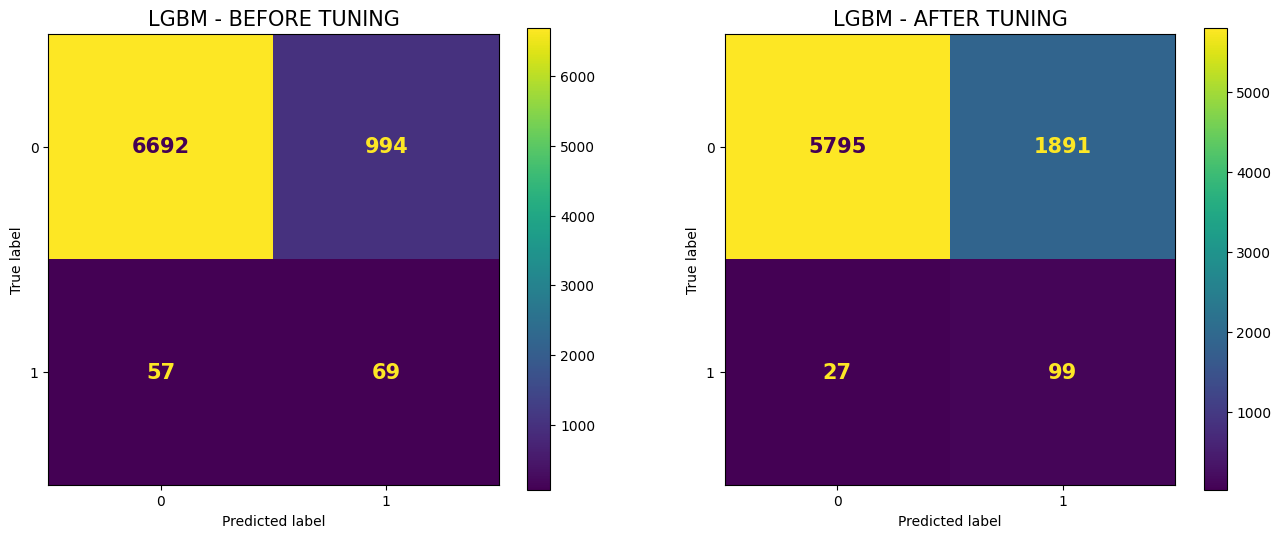

In [116]:
figure, axes = plt.subplots(ncols=2, figsize=(16,6))

text_format = {'size': 15, 'weight': 'bold'}


ConfusionMatrixDisplay(conf_matrix_before).plot(ax=axes[0],text_kw = text_format)

axes[0].set_title("LGBM - BEFORE TUNING", fontsize=15)

ConfusionMatrixDisplay(conf_matrix_after_lgbm).plot(ax=axes[1], text_kw = text_format)
axes[1].set_title("LGBM - AFTER TUNING", fontsize=15)

plt.show()

### Tuning HyperOpt - XGBoosts

In [117]:
pos_class_weight = (y == 0).sum() / (y == 1).sum() 
pos_class_weight

np.float64(61.197452229299365)

In [118]:
pipe_base_xgb = Pipeline([
    ("preprocessing", preprocessor),
    ("model", XGBClassifier(random_state=0, scale_pos_weight=pos_class_weight))
])

pipe_base_xgb.fit(X_train, y_train)

y_train_base = pipe_base_xgb.predict(X_train)
y_test_base = pipe_base_xgb.predict(X_test)


recall_train_base = recall_score(y_train, y_train_base)
recall_test_base = recall_score(y_test, y_test_base)

print(f"Train recall (Base Model): {recall_train_base:.4f}")
print(f"Test recall (Base Model): {recall_test_base:.4f}")

Train recall (Base Model): 1.0000
Test recall (Base Model): 0.2698


In [119]:
params_space = {
    "max_depth" : hp.choice("max_depth", range(3, 10, 1)), # untuk list-like search space
    "n_estimators": scope.int(hp.quniform("n_estimators", 50, 100, 5)), # untuk uniformly distributed (integer) search space
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)), # untuk loguniformly distributed searchspace
    "scale_pos_weight": hp.uniform("scale_pos_weight", 10, 100), # untuk uniformly distributed search space
    "min_child_weight": scope.int(hp.quniform("min_child_weight", 1, 30, 1)), # untuk uniformly distributed (integer) search space
    "max_delta_step": hp.choice("max_delta_step", [1,3, 5]) # untuk list-like search space
}

In [120]:
def objective(args):

    model_pipe = Pipeline([
        ("preprocessing", preprocessor),
        ("model", XGBClassifier(random_state=0, **args))
    ])

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    model_cv = cross_val_score(
        estimator=model_pipe,
        X=X_train,
        y=y_train,
        cv = kfold,
        scoring = 'recall'
    )

    loss_score = 1 - model_cv.mean() # Fungsi untuk di-optimasi (cari parameter yang membuat dia minimum)

    return loss_score

In [121]:
# Initiate a Trial object
trials = Trials()

tuning_result = fmin(fn=objective, # fungsi untuk diminimalisir costnya
                     space=params_space, # parameter space dengan distribusi probabilitas
                     algo=tpe.suggest, # algoritma tuning yg dipakai
                     max_evals=50,
                     trials=trials,
                     rstate=np.random.default_rng(0))

# Best params for trial
best_params = space_eval(params_space, tuning_result)

100%|██████████| 50/50 [02:38<00:00,  3.18s/trial, best loss: 0.1054059405940595]


In [122]:
best_params

{'learning_rate': 0.010992205604444402,
 'max_delta_step': 3,
 'max_depth': 3,
 'min_child_weight': 19,
 'n_estimators': 55,
 'scale_pos_weight': 95.93218391397204}

In [123]:
tuned_model = Pipeline([
    ("preprocessing", preprocessor),
    ("model", XGBClassifier(random_state=0, **best_params))
])

tuned_model.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [124]:
y_train_tuned_xgb = tuned_model.predict(X_train)
y_test_tuned_xgb = tuned_model.predict(X_test)

recall_train_tuned_xgb = recall_score(y_train, y_train_tuned_xgb)
recall_test_tuned_xgb = recall_score(y_test, y_test_tuned_xgb)

print("Evaluation Model: XGBoost")
print(f"Recall Train (Tuned Model): {recall_train_tuned_xgb}")
print(f"Recall Test (Tuned Model): {recall_test_tuned_xgb}")

Evaluation Model: XGBoost
Recall Train (Tuned Model): 0.9123505976095617
Recall Test (Tuned Model): 0.8888888888888888


In [125]:
y_pred_base = pipe_base_xgb.predict(X_test)

conf_matrix_before = confusion_matrix(y_test, y_test_base)
conf_matrix_after_xgb = confusion_matrix(y_test, y_test_tuned_xgb)

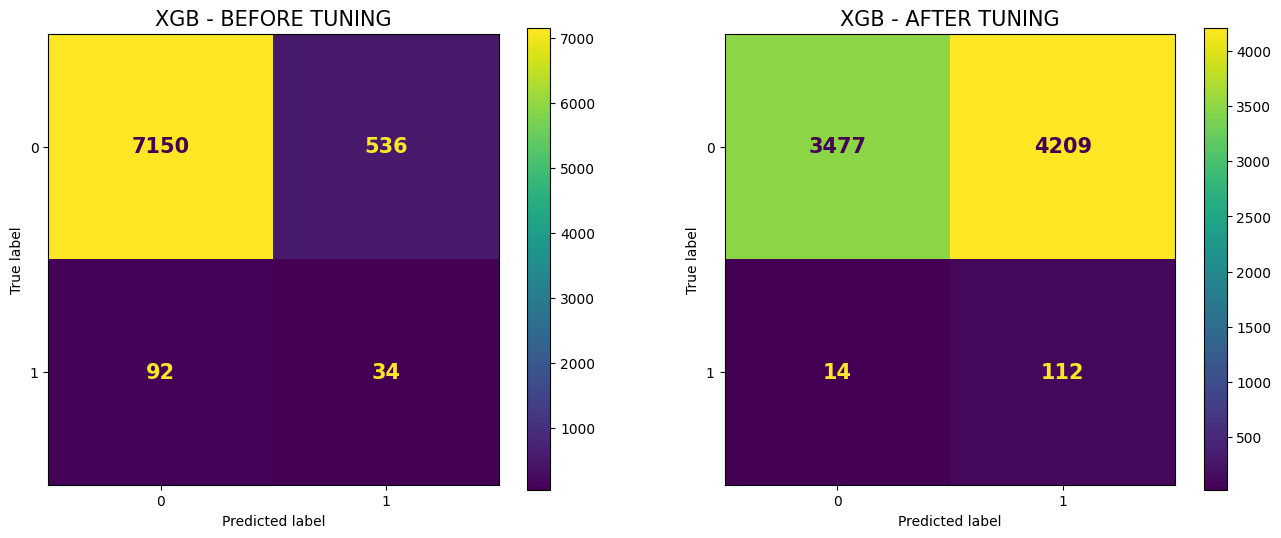

In [126]:
figure, axes = plt.subplots(ncols=2, figsize=(16,6))

text_format = {'size': 15, 'weight': 'bold'}


ConfusionMatrixDisplay(conf_matrix_before).plot(ax=axes[0],text_kw = text_format)

axes[0].set_title("XGB - BEFORE TUNING", fontsize=15)

ConfusionMatrixDisplay(conf_matrix_after_xgb).plot(ax=axes[1], text_kw = text_format)
axes[1].set_title("XGB - AFTER TUNING", fontsize=15)

plt.show()

## **9. Model Evaluation**

### **Cost Analysis**

In [127]:
fp_cost = 3250
fn_cost = 65000

In [128]:
def summarize_loss(confusion_matrix, fp_cost, fn_cost):
    tn, fp = confusion_matrix[0]
    fn, tp = confusion_matrix[1]
    
    total_samples = tn + fp + fn + tp
    total_fp_cost = fp * -1 * fp_cost
    total_fn_cost = fn * -1 * fn_cost
    
    total_cost = total_fp_cost + total_fn_cost
    
    summary = f"""
    ---Impact Summary---

        Total Samples: {total_samples}
        Total False Positive Cost: ${total_fp_cost:,.2f}
        Total False Negative Cost: ${total_fn_cost:,.2f}
        Total Benefit: ${total_cost:,.2f}
        
    ---------------
    """
    
    return summary

### Without Model

In [129]:
# predict semua akan tidak claim
print("TANPA MODEL:PREDIKSI SEMUA TIDAK CLAIM")
y_no_model = np.zeros(y_test.shape[0])
conf_matrix_no_model = confusion_matrix(y_test, y_no_model)
print(summarize_loss(conf_matrix_no_model, fp_cost=fp_cost, fn_cost=fn_cost))

TANPA MODEL:PREDIKSI SEMUA TIDAK CLAIM

    ---Impact Summary---

        Total Samples: 7812
        Total False Positive Cost: $0.00
        Total False Negative Cost: $-8,190,000.00
        Total Benefit: $-8,190,000.00

    ---------------
    


In [130]:
# predict semua akan claim
print("TANPA MODEL:PREDIKSI SEMUA CLAIM")
y_no_model = np.ones(y_test.shape[0])
conf_matrix_no_model = confusion_matrix(y_test, y_no_model)
print(summarize_loss(conf_matrix_no_model, fp_cost=fp_cost, fn_cost=fn_cost))

TANPA MODEL:PREDIKSI SEMUA CLAIM

    ---Impact Summary---

        Total Samples: 7812
        Total False Positive Cost: $-24,979,500.00
        Total False Negative Cost: $0.00
        Total Benefit: $-24,979,500.00

    ---------------
    


### With model - LogisticRegression

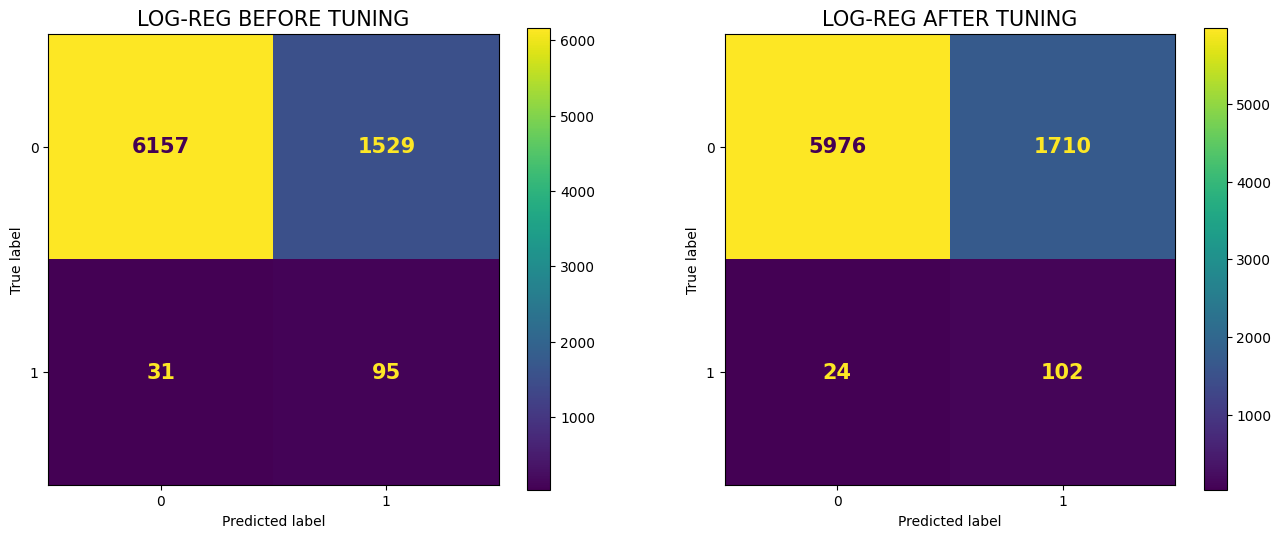

**-- With Model: Before Tuning --**

- FP cost = 1529 × 3250 = **4,969,250**

- FN cost = 31 × 65000 = **2,015,000**

- total cost = **6,984,250**

**-- With Model: After Tuning --**

- FP cost = 1710 × 3250 = **5,557,500**

- FN cost = 24 × 65000 = **1,560,000**

- Total cost = **7,117,500**

### With model - LGBMClassifier

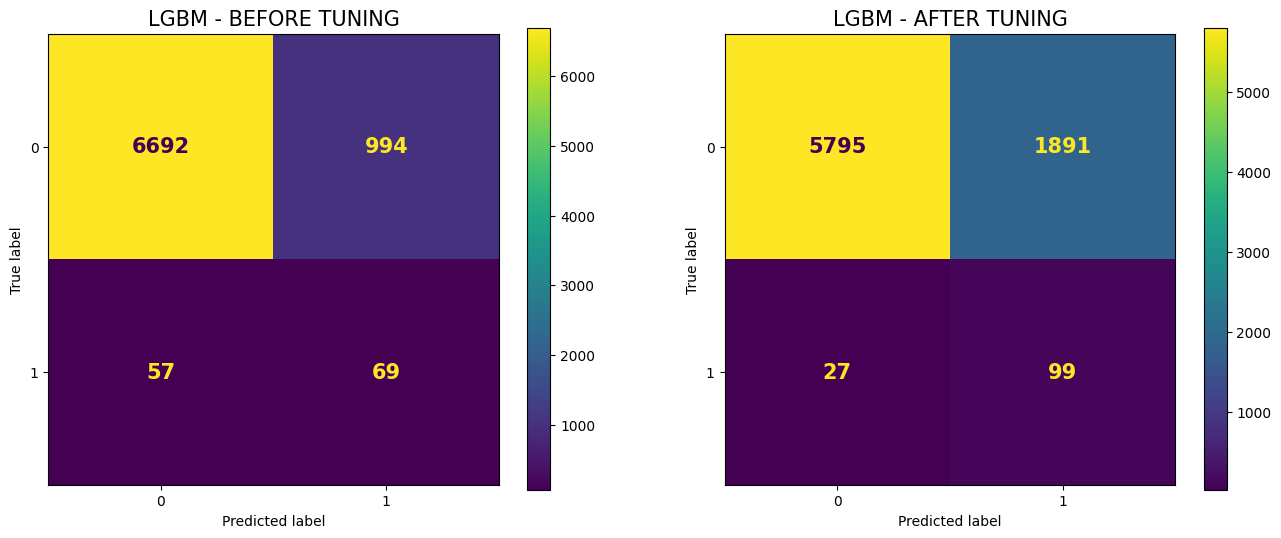

**-- With Model: Before Tuning --**

- FP cost = 994 × 3250 = **305,500**

- FN cost = 57 × 65000 = **3,705,000**

- total cost = **4,010,500**

**-- With Model: After Tuning --**

- FP cost = 1891 × 3250 = **6,145,750**

- FN cost = 27 × 65000 = **1,755,000**

- Total cost = **7,900,750**

### With model - XGBClassifier

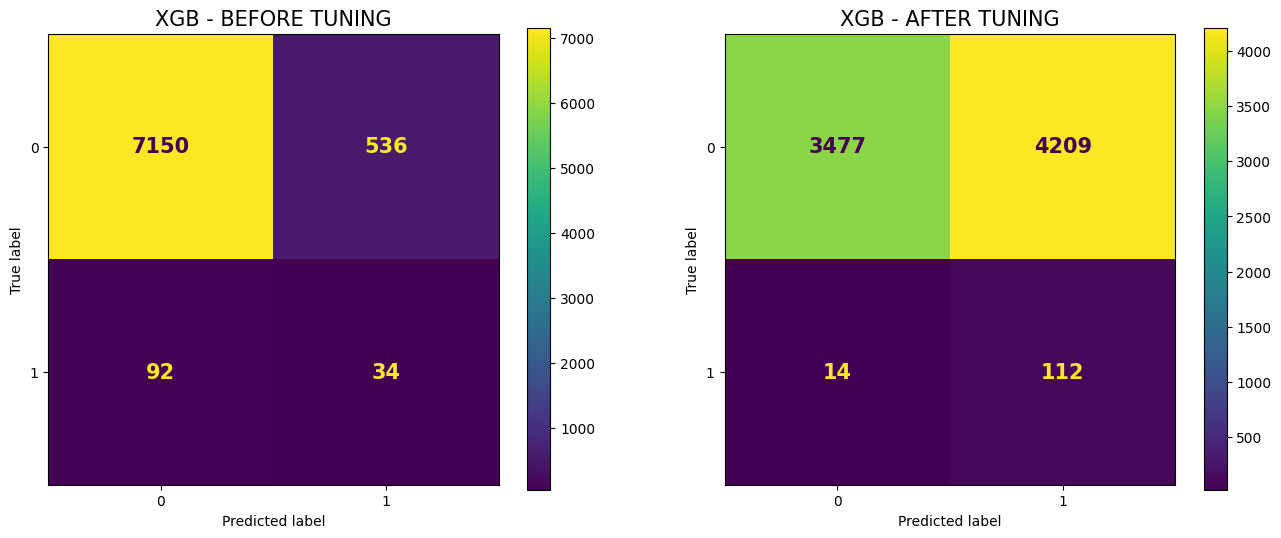

**-- With Model: Before Tuning --**

- FP cost = 536 × 3250 = **1,742,000**

- FN cost = 92 × 65000 = **5,980,000**

- total cost = **7,722,000**

**-- With Model: After Tuning --**

- FP cost = 4209 × 3250 = **13,679,250**

- FN cost = 14 × 65000 = **910,000**

- Total cost = **14,589,250**

**Summary**

Logistic Regression

- Before tuning: Total cost = **6,984,250**
- After tuning: Total cost = **7,117,500**
- Effect: Recall improved (Train: 0.71, Test: 0.81), but cost slightly increased due to more False Positives.

LGBMClassifier

- Before tuning: Total cost = **4,010,500**
- After tuning: Total cost = **7,900,750**
- Effect: Recall improved (Train: 0.80, Test: 0.79), False Negatives reduced, but False Positives increased sharply -> much higher total cost.

XGBoost

- Before tuning: Total cost = **7,722,000**
- After tuning: Total cost = **14,589,250**
- Effect: Recall significantly improved (Train: 0.91, Test: 0.89), False Negatives minimized, but False Positives exploded, leading to the highest cost overall.




### **10. Model Explanation**

Logistic Regression is the most appropriate choice compared to XGBoost and LightGBM because it delivers the **lowest overall cost** while maintaining a solid recall, making it far **more cost-efficient** in a dataset with **extreme imbalance** (98.4% no-claim vs 1.6% claim). Unlike XGBoost and LightGBM, which tend to overcompensate for the minority class and drastically increase false positives, driving costs up significantly. Logistic Regression achieves a **more balanced trade-off** between detecting claims and controlling operational expenses. In addition, its simplicity and interpretability are critical advantages in the insurance domain, where transparency and regulatory compliance are essential.


#### **The Working Mechanism of Logistic Regression**

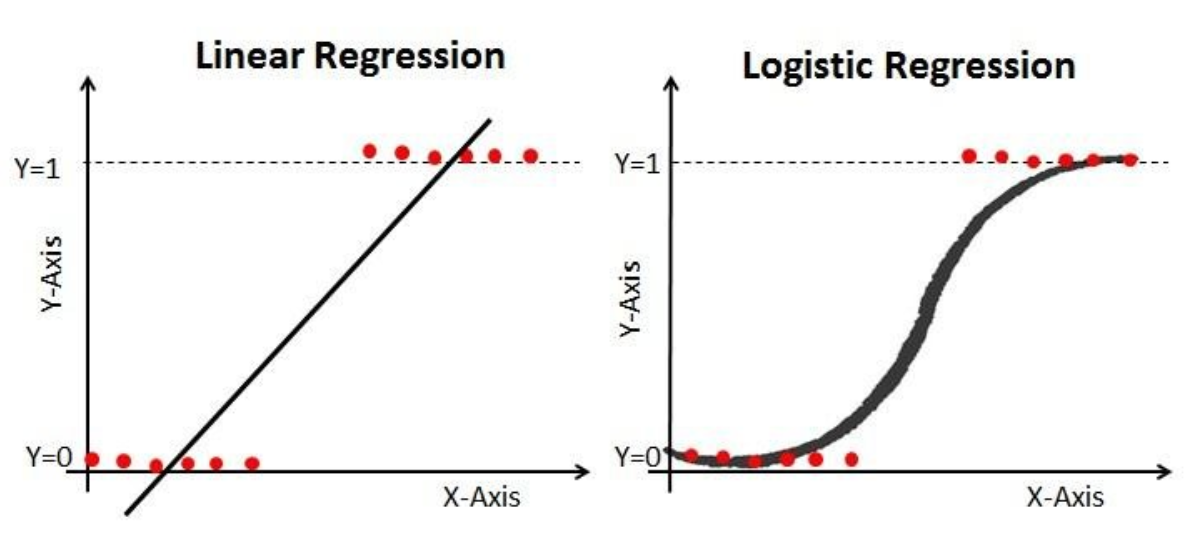

Logistic Regression is a classification method that models the relationship between a set of independent variables (features) and a binary dependent variable (e.g., claim vs. no claim). Unlike Linear Regression, which produces continuous outputs, Logistic Regression applies the logistic (sigmoid) function to map the linear combination of features into probabilities between 0 and 1. 

**Basic form is**:

$$P(y=1| X) = \frac{\text{exp}({\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n})}{1 + \text{exp}({\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n})}$$

**Decision rule**: If $P(y=1| X) \geq 0.5$, predict class 1; otherwise, predict class 0

#### **Evaluation**
1. Beta Parameter

Intercept (β0): -1.6836103306399914

Top 10 features with the highest |Beta| values:
           Feature      Beta  Abs_Beta
10  Product_name_0  2.038302  2.038302
11  Product_name_1  1.293621  1.293621
13  Product_name_3  1.072898  1.072898
6         Agency_0 -0.992949  0.992949
9         Agency_3 -0.921050  0.921050
14  Product_name_4  0.713629  0.713629
17   Destination_2 -0.597622  0.597622
7         Agency_1  0.594966  0.594966
12  Product_name_2  0.425517  0.425517
1        Net_sales  0.345696  0.345696


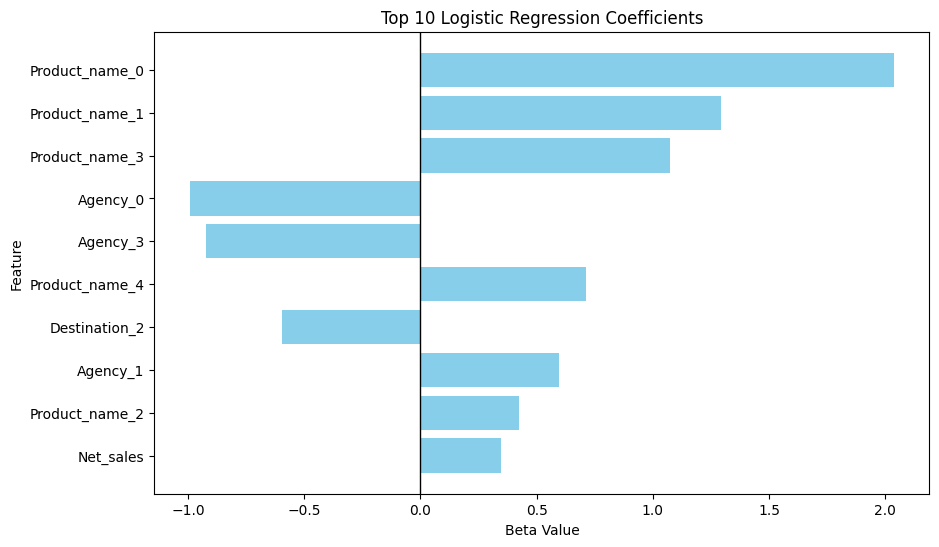

In [131]:
# Get feature names after preprocessing (pipeline transformations)
feature_names = best_model_log.named_steps["preprocessing"].get_feature_names_out()

# Extract logistic regression coefficients (beta values)
betas = best_model_log.named_steps["model"].coef_[0]
intercept = best_model_log.named_steps["model"].intercept_[0]

# Create a DataFrame with feature names and coefficients
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Beta": betas,
    "Abs_Beta": np.abs(betas)  # absolute value for ranking
}).sort_values(by="Abs_Beta", ascending=False)

# Print intercept and top 10 features by absolute coefficient values
print("Intercept (β0):", intercept)
print("\nTop 10 features with the highest |Beta| values:")
print(coef_df.head(10))

# Plot bar chart of the top 10 coefficients
top10 = coef_df.head(10)
plt.figure(figsize=(10,6))
plt.barh(top10["Feature"], top10["Beta"], color="skyblue")
plt.axvline(0, color="black", linewidth=1)  # reference line at 0
plt.title("Top 10 Logistic Regression Coefficients")
plt.xlabel("Beta Value")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # highest values on top
plt.show()

**Logistic Regression Coefficient Analysis**

The model identified the following features as having the strongest impact on predictions (ranked by absolute coefficient values):

- **Positive influence (increase likelihood of target = 1):**
  - `Product_name_0` (β ≈ +2.04)  
  - `Product_name_1` (β ≈ +1.29)  
  - `Product_name_3` (β ≈ +1.07)  
  - `Agency_1` (β ≈ +0.59)  
  - `Product_name_2` (β ≈ +0.43)  

- **Negative influence (increase likelihood of target = 0):**
  - `Agency_0` (β ≈ -0.99)  
  - `Agency_3` (β ≈ -0.92)  
  - `Destination_2` (β ≈ -0.60)  
  - `Product_name_4` (β ≈ -0.71)  
  - `Net_sales` (β ≈ +0.35, positive but weaker)  

**Interpretation**
- **Positive coefficients** indicate features that **raise the probability** of the positive class.  
- **Negative coefficients** indicate features that **lower the probability** of the positive class.  
- The **magnitude** of |β| reflects the relative importance of each feature: larger values mean stronger influence.  

**Key Insight**
- The model is heavily influenced by specific **product names** (e.g., `Product_name_0`, `Product_name_1`) and certain **agency categories** (`Agency_0`, `Agency_3`).  
- `Product_name_0` stands out as the single most impactful feature.  

2. Shap

c:\Users\nreva\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


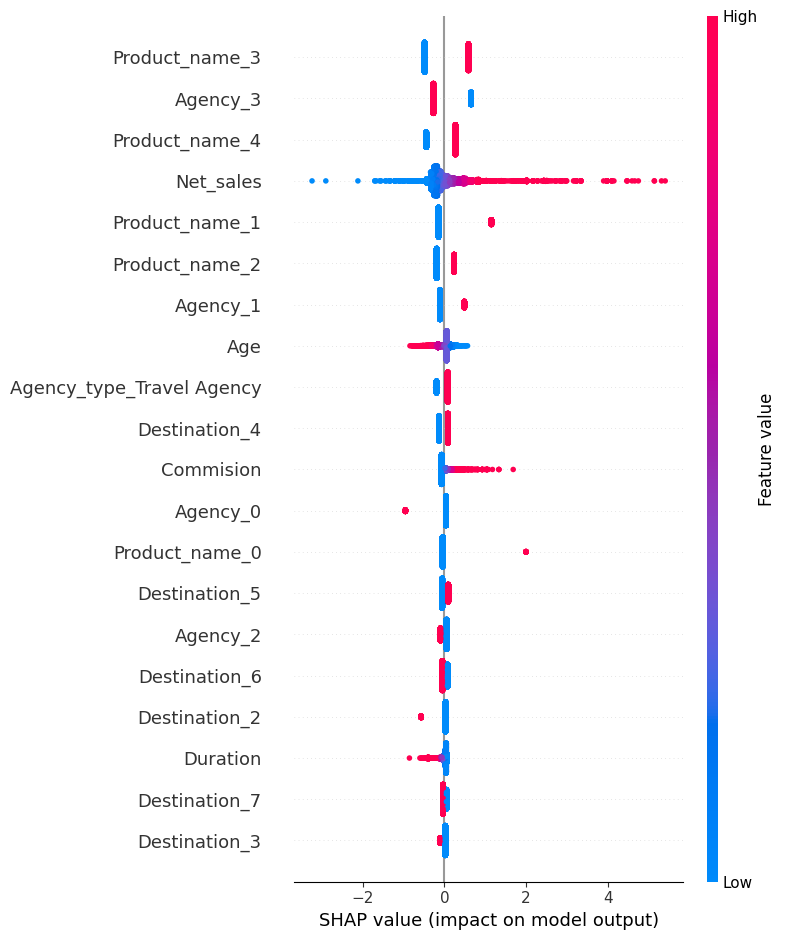

In [132]:
# 1) Transform features using the same preprocessing as during training
preproc = best_model_log.named_steps["preprocessing"]
X_train_t = preproc.transform(X_train)
X_test_t  = preproc.transform(X_test)
feat_names = preproc.get_feature_names_out()

# 2) Extract the trained logistic regression model
lr = best_model_log.named_steps["model"]

# 3) Build the SHAP explainer and compute SHAP values (on the log-odds scale)
explainer = shap.LinearExplainer(lr, X_train_t, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_t)

# 4) Display shap
plt.close('all')
shap.summary_plot(shap_values, X_test_t, feature_names=feat_names, show=True)


**SHAP Key Insights**

- **Most influential features**:  
  - `Agency_2` and `Net_sales` show the largest SHAP impacts, making them the strongest drivers of predictions.  
  - Other important contributors include `Product_name_3`, `Product_name_2`, `Agency_3`, and `Agency_type_Travel Agency`.  

- **Direction of influence**:  
  - **Positive SHAP values (to the right)** -> push predictions toward the positive class.  
  - **Negative SHAP values (to the left)** -> push predictions toward the negative class.  

- **Feature value coloring**:  
  - **Red** = higher feature values.  
  - **Blue** = lower feature values.  
  - Example: For `Net_sales`, high values (red) increase the predicted probability, while low values (blue) decrease it.  

- **Spread of SHAP points**:  
  - Wider spread = higher variability in how the feature affects different samples.  
  - `Net_sales` and `Agency_2` have both wide spread and strong impact → highly influential but context-dependent.  

- **Less impactful features**:  
  - Features such as `Commision`, `Destination_4`, and `Duration` show smaller SHAP impacts, meaning they contribute less to overall predictions.  


**Conclusion**:  
The model is strongly influenced by **agency-related variables** and **Net_sales**, with product categories also playing a significant role. Lower-ranked features have relatively minor contributions.


### **Model Limitation**

- The model can only be applied to data with the same structure and categorical values as seen during training. New or unseen categories in features (e.g., new `Agency` or `Destination`) cannot be handled unless the model is retrained.  
- Logistic Regression assumes a **linear relationship** between features and the log-odds of the outcome. This limits the model’s ability to capture complex, non-linear interactions among variables.  
- The dataset is highly **imbalanced** (claims are only ~1.6% of the records). Even with class balancing, the model still tends to generate many **false positives**, which increases operational standby costs.   
- Since the model is trained on **historical data**, its performance may degrade if customer behavior, product offerings, or travel patterns change over time. Regular retraining will be necessary.  
- Predictions are based on aggregate statistical patterns. The model cannot fully explain individual customer intentions or external factors (e.g., sudden travel bans, pandemics).  

## **10. Conclusion & Recommendation**

#### **Conclusion**

- The project successfully developed a machine learning model to predict the likelihood of travel insurance claims.  
- After comparing Logistic Regression, LightGBM, and XGBoost, **Logistic Regression** was selected as the final model because it provides the best balance between **recall performance (0.81 on test data)** and **financial cost efficiency**.  
- Ensemble models achieved higher recall but produced excessive False Positives, leading to sharp increases in standby fund allocation and overall costs.  
- Cost analysis confirmed that minimizing False Negatives (high-cost claims not anticipated) is more critical than reducing False Positives. Logistic Regression was most effective in keeping this trade-off balanced.  
- Feature importance analysis showed consistent results across both **coefficients** and **SHAP values**:  
  - **Most influential features** include `Net_sales`, `Agency` categories (Agency_0, Agency_1, Agency_2, Agency_3), and product names (`Product_name_0`, `Product_name_1`, `Product_name_3`).  
  - **SHAP analysis** reinforced that higher values of `Net_sales` and certain agency/product categories significantly increase the probability of claims.  

#### **Recomendation**
**Business**
1. **Risk-Based Premium Pricing**  
   - Use model predictions to assign fair premiums:  
     - High predicted claim risk -> adjusted higher premium to cover expected cost.  
     - Low predicted claim risk -> competitive pricing to attract more customers.  

2. **Customer Segmentation**  
   - Segment policyholders by predicted claim probability.  
   - Focus on **low-to-medium risk customers** for growth strategies, while applying stricter monitoring for high-risk segments.  

3. **Operational Risk Management**  
   - Align reserves with model outputs by allocating more standby funds for predicted high-risk policyholders.  
   - Reduce financial shocks by proactively managing customers most likely to submit claims.  

**Model**

1. **Model Monitoring & Improvement**  
   - Continuously track recall, False Negatives, and cost metrics to ensure stability.  
   - Retrain the model regularly with updated claim data to capture evolving travel patterns.  

2. **Future Enhancements**  
   - Explore **cost-sensitive learning** or custom loss functions to optimize directly for financial outcomes.  
   - Enrich the dataset with additional factors such as demographics, trip purpose, or travel frequency to further boost predictive accuracy.  
   - Consider testing hybrid models (e.g., stacking Logistic Regression with ensemble methods) for better risk calibration.  

**Validating Insurance Claims**
- claim validation ensure whether a claim is 'genuine' or 'fraudulent'
- Several ways to validate real claims:
    1. Documentation & evidence: by verifying tickets, visa, hospital/police reports, payment receipt
    2. Cross check: cross check with airlines, immigrations, or hospitals
    3. Chek their behavior: review customer's claim history and any suspicious behavior
    4. Direct investigation: high-risk claims that tend to be fraud should be investigated by professional investigators
- Highly consider the privacy and regulatory concerns when cross checking external data

## **12. Deployment Preparation**

#### **Save Model With All Train Data**

In [133]:
best_model_log.fit(X, y)

c:\Users\nreva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [134]:
print(best_model_log.get_params())

{'memory': None, 'steps': [('preprocessing', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['Duration', 'Net_sales', 'Commision', 'Age']),
                                ('cat',
                                 ColumnTransformer(transformers=[('onehot',
                                                                  OneHotEncoder(drop='first',
                                                                                handle_unknown='ignore',
                                                                                sparse_output=False),
                                                                  ['Agency_type',
                                                                   'Distribution_channel']),
                                                                 ('binary',
                                                                  BinaryEncoder(),
    

In [135]:
print(best_model_log.named_steps["model"].get_params())

{'C': 0.1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [136]:
with open("travel_insurance_claim_model.sav", "wb") as f:
    pickle.dump(tuned_model, f)

#### **Streamlit Data Preparation**

In [137]:
pd.set_option('display.max_colwidth', None)

cat_cols = X.select_dtypes(exclude='number').columns

unique_values_df = pd.DataFrame({
    'column': cat_cols,
    'n_unique': [X[col].nunique() for col in cat_cols],
    'unique_values': [", ".join(map(str, X[col].unique().tolist())) for col in cat_cols]
})

unique_values_df

,column,n_unique,unique_values
0,Agency,15,"C2B, EPX, JZI, CWT, LWC, ART, CSR, RAB, KML, SSI, TST, TTW, ADM, CCR, CBH"
1,Agency_type,2,"Airlines, Travel Agency"
2,Distribution_channel,2,"Online, Offline"
3,Product_name,26,"Annual Silver Plan, Cancellation Plan, Basic Plan, 2 way Comprehensive Plan, Bronze Plan, 1 way Comprehensive Plan, Rental Vehicle Excess Insurance, Single Trip Travel Protect Gold, Silver Plan, Value Plan, 24 Protect, Annual Travel Protect Gold, Comprehensive Plan, Ticket Protector, Travel Cruise Protect, Single Trip Travel Protect Silver, Individual Comprehensive Plan, Gold Plan, Annual Gold Plan, Child Comprehensive Plan, Premier Plan, Annual Travel Protect Silver, Single Trip Travel Protect Platinum, Annual Travel Protect Platinum, Spouse or Parents Comprehensive Plan, Travel Cruise Protect Family"
4,Destination,136,"SINGAPORE, MALAYSIA, INDIA, UNITED STATES, KOREA, REPUBLIC OF, THAILAND, GERMANY, JAPAN, INDONESIA, VIET NAM, AUSTRALIA, FINLAND, UNITED KINGDOM, SRI LANKA, SPAIN, HONG KONG, MACAO, CHINA, UNITED ARAB EMIRATES, IRAN, ISLAMIC REPUBLIC OF, TAIWAN, PROVINCE OF CHINA, POLAND, CANADA, OMAN, PHILIPPINES, GREECE, BELGIUM, TURKEY, BRUNEI DARUSSALAM, DENMARK, SWITZERLAND, NETHERLANDS, SWEDEN, MYANMAR, KENYA, CZECH REPUBLIC, FRANCE, RUSSIAN FEDERATION, PAKISTAN, ARGENTINA, TANZANIA, UNITED REPUBLIC OF, SERBIA, ITALY, CROATIA, NEW ZEALAND, PERU, MONGOLIA, CAMBODIA, QATAR, NORWAY, LUXEMBOURG, MALTA, LAO PEOPLE'S DEMOCRATIC REPUBLIC, ISRAEL, SAUDI ARABIA, AUSTRIA, PORTUGAL, NEPAL, UKRAINE, ESTONIA, ICELAND, BRAZIL, MEXICO, CAYMAN ISLANDS, PANAMA, BANGLADESH, TURKMENISTAN, BAHRAIN, KAZAKHSTAN, TUNISIA, IRELAND, ETHIOPIA, NORTHERN MARIANA ISLANDS, MALDIVES, SOUTH AFRICA, VENEZUELA, COSTA RICA, JORDAN, MALI, CYPRUS, MAURITIUS, LEBANON, KUWAIT, AZERBAIJAN, HUNGARY, BHUTAN, BELARUS, MOROCCO, ECUADOR, UZBEKISTAN, CHILE, FIJI, PAPUA NEW GUINEA, ANGOLA, FRENCH POLYNESIA, NIGERIA, MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF, NAMIBIA, GEORGIA, COLOMBIA, SLOVENIA, EGYPT, ZIMBABWE, BULGARIA, BERMUDA, URUGUAY, GUINEA, GHANA, BOLIVIA, TRINIDAD AND TOBAGO, VANUATU, GUAM, UGANDA, JAMAICA, LATVIA, ROMANIA, REPUBLIC OF MONTENEGRO, KYRGYZSTAN, GUADELOUPE, ZAMBIA, RWANDA, BOTSWANA, GUYANA, LITHUANIA, GUINEA-BISSAU, SENEGAL, CAMEROON, SAMOA, PUERTO RICO, TAJIKISTAN, ARMENIA, FAROE ISLANDS, DOMINICAN REPUBLIC, MOLDOVA, REPUBLIC OF, BENIN, REUNION"


In [138]:
X.describe()

,Duration,Net_sales,Commision,Age
count,39060.000000,39060.000000,39060.000000,39060.000000
mean,50.810215,42.047178,10.271456,38.976754
std,74.678175,49.602070,20.279449,10.479616
min,1.000000,-357.500000,0.000000,0.000000
25%,11.000000,19.000000,0.000000,34.000000
50%,25.000000,28.000000,0.000000,36.000000
75%,57.000000,49.500000,11.880000,44.000000
max,740.000000,682.000000,262.760000,88.000000


#### **Library Version Check**

In [139]:
np.__version__

'2.2.1'

In [140]:
pd.__version__

'2.3.1'

In [141]:
import matplotlib

matplotlib.__version__

'3.10.5'

In [142]:
sns.__version__

'0.13.2'

In [143]:
msno.__version__

'0.5.2'

In [144]:
import sklearn

sklearn.__version__

'1.7.1'

In [145]:
import category_encoders

category_encoders.__version__

'2.8.1'

In [146]:
import xgboost

xgboost.__version__

'3.0.4'

In [147]:
import lightgbm

lightgbm.__version__

'4.6.0'

In [148]:
import imblearn

imblearn.__version__

'0.14.0'

In [149]:
import hyperopt

hyperopt.__version__

'0.2.7'

In [150]:
shap.__version__

'0.48.0'

**Export data to csv**

In [151]:
train_df = X_train.copy()
train_df["Target"] = y_train.values

test_df = X_test.copy()
test_df["Target"] = y_test.values

train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

print("Train and test data exported successfully!")

df.to_csv("data_cleaned.csv", index=False)

print("Data cleaned exported successfully!")

Train and test data exported successfully!
Data cleaned exported successfully!


In [152]:
# bikin data dummies dalam csv